# Estimating Parking Cost and Spatial Autocorrelation Analysis of Parking Data

Goals:
   1. Join csv cost data with spatial data for parking lots
   2. Make maps to show data
   3. Estimate Ratios of M to D, D to H, M to H to estimate missing rates values.
   4. Global and Local Spatial Autocorrelation (Moran's I and Getis-Ord Gi*)
       - If Local Spatial Autocorrelation found - attempt interpolation methodologies:
           - Kriging
           - IDW

       - If Local Spatial Autocorrelation is not found - summarize estimated parking lot rates according to areal polygons:
           - "Districts"
           - Drawn Areal Polygons

For future: https://www.inflationtool.com/us-dollar/2010-to-present-value    

Sources:
- https://notebook.community/ocefpaf/folium/examples/Colormaps
- https://nbviewer.org/github/FloChehab/folium/blob/fix_choropleth/examples/GeoJSON_and_choropleth.ipynb
- https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html
- https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html
- https://gdal.org/programs/gdal_grid.html#interpolation-algorithms
- https://github.com/pysal/esda/tree/master/esda
- https://geographicdata.science/book/notebooks/04_spatial_weights.html

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import pysal
from esda.getisord import G_Local #spatial autocorrelation
from sklearn.gaussian_process import GaussianProcessRegressor #kriging
from osgeo import ogr #delauney triangles and IDW interpolation
from osgeo import gdal
import folium # interactive mapping
import branca.colormap as cm # for interactive mapping
import osmnx as ox
import networkx as nx
import copy
import libpysal as lps
from libpysal import weights
from libpysal.weights.util import full2W
from libpysal.weights.util import WSP
from esda.moran import Moran #spatial autocorrelation
from esda.moran import Moran_Local
import scipy
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
import keplergl

## Bring In Data

1. Lot Rates
2. Lot Points
3. Join Points and Rates
4. Filter Lots (must have at least one rate)
5. TAZs
6. Attraction Districts
7. Merge and Dissolve TAZs to Attraction Districts

In [2]:
# bring in data
base = "J:\Shared drives\TMD_TSA\Data\Parking\WebScraped_ParkingCost"
# parking costs
rates = pd.read_csv(base+"\parking_cost_fullrec_NAP_F16.csv")

# spatial points
points = gpd.read_file(base+"\GeocodedParkingLots\DKedits_parking_cost_fullrec_NAP.shp")
points = points.dropna(subset=["geometry"])

# join cost to points
lots = points[['IN_SingleL','geometry','USER_month','USER_lot_u']].merge(rates[['IN_SingleLine','USER_lot_url', 'MR','DR','HR']],
                                                                         left_on='USER_lot_u',right_on='USER_lot_url')
# drop lots of columns
# reproject for easier mapping (From mass state plane to wgs84)
lots = lots.to_crs("EPSG:4326")

# filter out customer only parking (no rates for any category)
lots = lots[(~lots['MR'].isna()) | (~lots['DR'].isna()) | (~lots['HR'].isna())]

In [3]:
# bring in relevant TAZs
base2 = "J:\Shared drives\TMD_TSA\Data\GIS Data\TAZ"
alltazs = gpd.read_file(base2+"\\candidate_CTPS_TAZ_STATEWIDE_2019_wgs84.shp")
# filter to just relevant municipalities
districts = alltazs[(alltazs['town'].isin(["BOSTON","CAMBRIDGE","SOMERVILLE","BROOKLINE","NEWTON"])) & (alltazs['id'] < 200000)][["id","town","geometry"]]

# bring in TAZ to attraction districts table
base3 = "J:\Shared drives\TMD_TSA\Data\GIS Data\\trip_attr_districts"
tazdists = pd.read_csv(base3+"\\taz_attr_dist_at.csv")

# join the district names to the tazs by id
districts = districts.merge(tazdists, on = "id")
# dissolve taz to districts                       
districts = districts.dissolve(by="attr_dist")
districts

geometry  \
attr_dist                                                                   
Allston, Dense          POLYGON ((-71.13443 42.34666, -71.13455 42.346...   
Allston, Urban          MULTIPOLYGON (((-71.13110 42.35614, -71.13098 ...   
Area 2/MIT, Dense       POLYGON ((-71.10432 42.35241, -71.10601 42.352...   
Assembly Square, Dense  POLYGON ((-71.08170 42.39008, -71.08208 42.390...   
Assembly Square, Urban  POLYGON ((-71.07767 42.38699, -71.07804 42.387...   
...                                                                   ...   
West End, Dense         POLYGON ((-71.05997 42.36301, -71.06055 42.362...   
West Roxbury, Suburban  POLYGON ((-71.19042 42.28160, -71.19051 42.281...   
West Roxbury, Urban     POLYGON ((-71.16687 42.26179, -71.16687 42.261...   
Winter Hill, Dense      POLYGON ((-71.08820 42.38961, -71.08838 42.389...   
Winter Hill, Urban      POLYGON ((-71.09429 42.38677, -71.09483 42.387...   

                         id        town at_3level  
attr_dist                                          
Allston, Dense          234      BOSTON     Dense  
Allston, Urban          238      BOSTON     Urban  
Area 2/MIT, Dense       645   CAMBRIDGE     Dense  
Assembly Square, Dense  594  SOMERVILLE     Dense  
Assembly Square, Urban  593  SOMERVILLE     Urban  
...                     ...         ...       ...  
West End, Dense          24      BOSTON     Dense  
West Roxbury, Suburban  447      BOSTON  Suburban  
West Roxbury, Urban     436      BOSTON     Urban  
Winter Hill, Dense      599  SOMERVILLE     Dense  
Winter Hill, Urban      597  SOMERVILLE     Urban  

[85 rows x 4 columns]

### Calculate Mean & Median Rates per District
This is to aggregate data per district instead of at the point level.

In [4]:
# spatial join - for every lot get district
lotdist = lots.sjoin(districts.reset_index(), how="left")
# group by and get mean, median, mode for each rate column
hrmean = lotdist.groupby('attr_dist')['HR'].mean().rename("Hourly_Rate_Mean")
hrmed = lotdist.groupby('attr_dist')['HR'].median().rename("Hourly_Rate_Median")

drmean = lotdist.groupby('attr_dist')['DR'].mean().rename("Daily_Rate_Mean")
drmed = lotdist.groupby('attr_dist')['DR'].median().rename("Daily_Rate_Median")

mrmean = lotdist.groupby('attr_dist')['MR'].mean().rename("Monthly_Rate_Mean")
mrmed = lotdist.groupby('attr_dist')['MR'].median().rename("Monthly_Rate_Median")

# turn geoseries into table
ratesdist = pd.concat([hrmean, hrmed, drmean, drmed, mrmean, mrmed], axis=1)
ratesdistgeo = districts.merge(ratesdist, on = "attr_dist").reset_index()
ratesdistgeo.head()

attr_dist                                           geometry  \
0          Allston, Dense  POLYGON ((-71.13443 42.34666, -71.13455 42.346...   
1       Area 2/MIT, Dense  POLYGON ((-71.10432 42.35241, -71.10601 42.352...   
2  Assembly Square, Dense  POLYGON ((-71.08170 42.39008, -71.08208 42.390...   
3  Assembly Square, Urban  POLYGON ((-71.07767 42.38699, -71.07804 42.387...   
4        BROOKLINE, Dense  POLYGON ((-71.13129 42.33177, -71.13140 42.331...   

    id        town at_3level  Hourly_Rate_Mean  Hourly_Rate_Median  \
0  234      BOSTON     Dense          0.250000                 0.0   
1  645   CAMBRIDGE     Dense          6.750000                 6.0   
2  594  SOMERVILLE     Dense          0.333333                 0.0   
3  593  SOMERVILLE     Urban          0.000000                 0.0   
4  739   BROOKLINE     Dense          4.666667                 6.0   

   Daily_Rate_Mean  Daily_Rate_Median  Monthly_Rate_Mean  Monthly_Rate_Median  
0        17.000000               17.0         158.333333                150.0  
1        33.666667               34.0                NaN                  NaN  
2        25.000000               25.0                NaN                  NaN  
3              NaN                NaN                NaN                  NaN  
4        30.000000               30.0         195.000000                200.0

## Estimate and Fill Missing Monthly Rates

Calculate the Monthly/Daily ratio per district by dividing the monthly column by the daily column to get lot level ratios and aggregate to the region. This region-wide ratio is multiplied by each lot's Daily Rate to calculate an estimated monthly rate. At this point, a new column is made where observed monthly rate data unless missing, then estimated monthly rate data is used if existing (aka if lot has a daily rate). 

This will be conducted for M/D, D/H, and M/H - M/D is used as the example for the explanation for ease of understanding.

### Monthly to Daily

In [5]:
#copy from prior section
estmonth = copy.copy(lotdist)
#get ratio at the lot level
estmonth['Monthly_to_Daily'] = estmonth['MR']/estmonth['DR']
estmonth[estmonth['Monthly_to_Daily'] > 0]

IN_SingleL                    geometry  \
7      11 Stillings St Boston, MA 02210, US  POINT (-71.04717 42.35030)   
8        16 Charles St Boston, MA 02108, US  POINT (-71.06826 42.35432)   
9          40 Beach St Boston, MA 02111, US  POINT (-71.06159 42.35165)   
12   660 Washington St Boston, MA 02111, US  POINT (-71.06253 42.35172)   
13     19 Lancaster St Boston, MA 02114, US  POINT (-71.06214 42.36409)   
..                                      ...                         ...   
454       1 Sawyer Rd Waltham, MA 02453, US  POINT (-71.26032 42.36179)   
455     200 Webster St Newton, MA 02466, US  POINT (-71.23432 42.34777)   
456          Auburn St Newton, MA 02466, US  POINT (-71.25122 42.34573)   
457        91 Wyman St Newton, MA 02468, US  POINT (-71.23017 42.32636)   
458       367 Grove St Newton, MA 02466, US  POINT (-71.25257 42.33662)   

              USER_month                                         USER_lot_u  \
7    Monthly:  $150-$480  https://www.parkme.com/lot/32201/stillings-gar...   
8    Monthly:  $150-$400                   https://www.parkme.com/lot/32172   
9    Monthly:  $165-$335  https://www.parkme.com/lot/75578/40-beach-st?e...   
12   Monthly:  $335-$395  https://www.parkme.com/lot/15258/660-washingto...   
13        Monthly:  $465                   https://www.parkme.com/lot/24108   
..                   ...                                                ...   
454        Monthly:  $70                  https://www.parkme.com/lot/215055   
455        Monthly:  $70                  https://www.parkme.com/lot/215060   
456       Monthly:  $105                  https://www.parkme.com/lot/215043   
457    Monthly:  $157.50                  https://www.parkme.com/lot/215119   
458       Monthly:  $105                  https://www.parkme.com/lot/215128   

                               IN_SingleLine  \
7      11 Stillings St Boston, MA 02210, US    
8        16 Charles St Boston, MA 02108, US    
9          40 Beach St Boston, MA 02111, US    
12   660 Washington St Boston, MA 02111, US    
13     19 Lancaster St Boston, MA 02114, US    
..                                       ...   
454       1 Sawyer Rd Waltham, MA 02453, US    
455     200 Webster St Newton, MA 02466, US    
456          Auburn St Newton, MA 02466, US    
457        91 Wyman St Newton, MA 02468, US    
458       367 Grove St Newton, MA 02466, US    

                                          USER_lot_url     MR    DR    HR  \
7    https://www.parkme.com/lot/32201/stillings-gar...  480.0  25.0  12.0   
8                     https://www.parkme.com/lot/32172  400.0  28.0  10.0   
9    https://www.parkme.com/lot/75578/40-beach-st?e...  335.0  28.0  12.0   
12   https://www.parkme.com/lot/15258/660-washingto...  395.0  27.0  13.0   
13                    https://www.parkme.com/lot/24108  465.0  25.0  13.0   
..                                                 ...    ...   ...   ...   
454                  https://www.parkme.com/lot/215055   70.0   4.0   NaN   
455                  https://www.parkme.com/lot/215060   70.0   4.0   NaN   
456                  https://www.parkme.com/lot/215043  105.0   6.0   NaN   
457                  https://www.parkme.com/lot/215119  157.5   9.0   NaN   
458                  https://www.parkme.com/lot/215128  105.0   6.0   NaN   

     index_right                       attr_dist      id    town at_3level  \
7           64.0  South Boston Waterfront, Dense   144.0  BOSTON     Dense   
8           12.0              Beacon Hill, Dense    30.0  BOSTON     Dense   
9           23.0                Chinatown, Dense    77.0  BOSTON     Dense   
12          23.0                Chinatown, Dense    77.0  BOSTON     Dense   
13          80.0                 West End, Dense    24.0  BOSTON     Dense   
..           ...                             ...     ...     ...       ...   
454          NaN                             NaN     NaN     NaN       NaN   
455         53.0                   NEWTON, Urban  1040.0 

In [6]:
# Get the mean ratio for the region
estmonth['Monthly_to_Daily'].mean()

14.942536419878438

In [7]:
# estimate monthly from daily and mean regional ratio (using only where both values)
estmonth['Est_Monthly'] = estmonth['DR'] * estmonth['Monthly_to_Daily'].mean()

# combine estimated daily with actual daily where possible
estmonth['Monthly_Rate_wEst'] = np.where(estmonth['MR'].isna(),
                                         estmonth['Est_Monthly'],
                                         estmonth['MR'])

### Daily to Hourly

In [8]:
#get D to H ratio at the lot level
# if divide by 0, just set to 0
estmonth['Daily_to_Hourly'] = np.where(estmonth['HR'] == 0,None,estmonth['DR']/estmonth['HR'])
estmonth[estmonth['Daily_to_Hourly'] > 0]

IN_SingleL                    geometry  \
0          208 Friend St Boston, MA 02114, US  POINT (-71.06078 42.36407)   
1        21 Lancaster St Boston, MA 02114, US  POINT (-71.06214 42.36409)   
2              28 Ash St Boston, MA 02111, US  POINT (-71.06336 42.34869)   
3            33 Essex St Boston, MA 02111, US  POINT (-71.05591 42.35267)   
4         47 Lagrange St Boston, MA 02116, US  POINT (-71.06409 42.35172)   
..                                        ...                         ...   
430  45 University Rd Cambridge, MA 02138, US  POINT (-71.12409 42.37260)   
437         88 Exeter St Boston, MA 02116, US  POINT (-71.07882 42.34861)   
438     210 Columbus Ave Boston, MA 02116, US  POINT (-71.07195 42.34824)   
439         35 Exeter St Boston, MA 02116, US  POINT (-71.07999 42.34992)   
444     11 Hinsdale Mall Boston, MA 02215, US  POINT (-71.10309 42.34934)   

              USER_month                         USER_lot_u  \
0     Mon-Fri:  6am-12am   https://www.parkme.com/lot/15284   
1     Mon-Fri:  6am-12am   https://www.parkme.com/lot/15286   
2     Mon-Sun:  24 Hours   https://www.parkme.com/lot/32124   
3      Mon-Fri:  6am-2am   https://www.parkme.com/lot/15268   
4     Mon-Sun:  24 Hours   https://www.parkme.com/lot/24171   
..                   ...                                ...   
430  Monthly:  $205-$455   https://www.parkme.com/lot/53525   
437   Mon-Sun:  24 Hours  https://www.parkme.com/lot/188670   
438   Mon-Sun:  24 Hours  https://www.parkme.com/lot/197418   
439   Mon-Sat:  7am-12am   https://www.parkme.com/lot/32166   
444   Mon-Sun:  24 Hours  https://www.parkme.com/lot/110734   

                                 IN_SingleLine  \
0          208 Friend St Boston, MA 02114, US    
1        21 Lancaster St Boston, MA 02114, US    
2              28 Ash St Boston, MA 02111, US    
3            33 Essex St Boston, MA 02111, US    
4         47 Lagrange St Boston, MA 02116, US    
..                                         ...   
430  45 University Rd Cambridge, MA 02138, US    
437         88 Exeter St Boston, MA 02116, US    
438     210 Columbus Ave Boston, MA 02116, US    
439         35 Exeter St Boston, MA 02116, US    
444     11 Hinsdale Mall Boston, MA 02215, US    

                          USER_lot_url     MR    DR    HR  index_right  \
0     https://www.parkme.com/lot/15284    NaN  25.0  10.0         80.0   
1     https://www.parkme.com/lot/15286    NaN  25.0  10.0         80.0   
2     https://www.parkme.com/lot/32124    NaN  23.0  10.0         23.0   
3     https://www.parkme.com/lot/15268    NaN  30.0  10.0         27.0   
4     https://www.parkme.com/lot/24171    NaN  25.0  10.0         27.0   
..                                 ...    ...   ...   ...          ...   
430   https://www.parkme.com/lot/53525  455.0  31.0  12.0         78.0   
437  https://www.parkme.com/lot/188670    NaN  44.0   9.0          8.0   
438  https://www.parkme.com/lot/197418    NaN  23.0  12.0          8.0   
439   https://www.parkme.com/lot/32166    NaN  38.0  20.0          8.0   
444  https://www.parkme.com/lot/110734    NaN  12.0   8.0         33.0   

                 attr_dist     id       town at_3level  Monthly_to_Daily  \
0          West End, Dense   24.0     BOSTON     Dense               NaN   
1          West End, Dense   24.0     BOSTON     Dense               NaN   
2         Chinatown, Dense   77.0     BOSTON     Dense               NaN   
3          Downtown, Dense   19.0     BOSTON     Dense               NaN   
4          Downtown, Dense   19.0     BOSTON     Dense               NaN   
..                     ...    ...        ...       ...               ...   
430  West Cambridge, Dense  693.0  CAMBRIDGE     Dense         14.677419   
437        Back Bay, Dense   94.0     BOSTON     Dense               NaN   
438        Back Bay, Dense   94.0     BOSTON     Dense               NaN   
439        Back Bay, Dense   94.0     BOSTON     Dense               NaN   
444          Fenway, Dense 

In [9]:
# calculate regional mean of D to H ratio
estmonth['Daily_to_Hourly'].mean()

2.933415430151465

In [10]:
# estimate Daily from Hourly and mean regional ratio (using only where both values)
estmonth['Est_Daily'] = estmonth['HR'] * estmonth['Daily_to_Hourly'].mean()

# combine estimated daily with actual daily where possible
estmonth['Daily_Rate_wEst'] = np.where(estmonth['DR'].isna(),
                                         estmonth['Est_Daily'],
                                         estmonth['DR'])

### Monthly to Hourly 
(Derived from Daily to Hourly Ratio and Monthly to Daily Ratio)

In [11]:
#get Monthly to Hourly ratio at the lot level
# if divide by 0, just set to 0
estmonth['Monthly_to_Hourly'] = estmonth['Daily_to_Hourly']*estmonth['Monthly_to_Daily']
estmonth[~estmonth['Monthly_to_Hourly'].isna()]

IN_SingleL                    geometry  \
7        11 Stillings St Boston, MA 02210, US  POINT (-71.04717 42.35030)   
8          16 Charles St Boston, MA 02108, US  POINT (-71.06826 42.35432)   
9            40 Beach St Boston, MA 02111, US  POINT (-71.06159 42.35165)   
12     660 Washington St Boston, MA 02111, US  POINT (-71.06253 42.35172)   
13       19 Lancaster St Boston, MA 02114, US  POINT (-71.06214 42.36409)   
..                                        ...                         ...   
337     720 Harrison Ave Boston, MA 02118, US  POINT (-71.07094 42.33774)   
338     835 Columbus Ave Boston, MA 02120, US  POINT (-71.08831 42.33630)   
347     720 E Concord St Boston, MA 02118, US  POINT (-71.07079 42.33488)   
396          1 Evelyn Pl Malden, MA 02148, US  POINT (-71.07492 42.42821)   
430  45 University Rd Cambridge, MA 02138, US  POINT (-71.12409 42.37260)   

              USER_month                                         USER_lot_u  \
7    Monthly:  $150-$480  https://www.parkme.com/lot/32201/stillings-gar...   
8    Monthly:  $150-$400                   https://www.parkme.com/lot/32172   
9    Monthly:  $165-$335  https://www.parkme.com/lot/75578/40-beach-st?e...   
12   Monthly:  $335-$395  https://www.parkme.com/lot/15258/660-washingto...   
13        Monthly:  $465                   https://www.parkme.com/lot/24108   
..                   ...                                                ...   
337       Monthly:  $300                   https://www.parkme.com/lot/32181   
338  Monthly:  $125-$350                   https://www.parkme.com/lot/26200   
347       Monthly:  $249                   https://www.parkme.com/lot/80468   
396  Monthly:  $135-$150  https://www.parkme.com/lot/187380/malden-gatew...   
430  Monthly:  $205-$455                   https://www.parkme.com/lot/53525   

                                 IN_SingleLine  \
7        11 Stillings St Boston, MA 02210, US    
8          16 Charles St Boston, MA 02108, US    
9            40 Beach St Boston, MA 02111, US    
12     660 Washington St Boston, MA 02111, US    
13       19 Lancaster St Boston, MA 02114, US    
..                                         ...   
337     720 Harrison Ave Boston, MA 02118, US    
338     835 Columbus Ave Boston, MA 02120, US    
347     720 E Concord St Boston, MA 02118, US    
396          1 Evelyn Pl Malden, MA 02148, US    
430  45 University Rd Cambridge, MA 02138, US    

                                          USER_lot_url     MR    DR    HR  \
7    https://www.parkme.com/lot/32201/stillings-gar...  480.0  25.0  12.0   
8                     https://www.parkme.com/lot/32172  400.0  28.0  10.0   
9    https://www.parkme.com/lot/75578/40-beach-st?e...  335.0  28.0  12.0   
12   https://www.parkme.com/lot/15258/660-washingto...  395.0  27.0  13.0   
13                    https://www.parkme.com/lot/24108  465.0  25.0  13.0   
..                                                 ...    ...   ...   ...   
337                   https://www.parkme.com/lot/32181  300.0  40.0   8.0   
338                   https://www.parkme.com/lot/26200  350.0  38.0  12.0   
347                   https://www.parkme.com/lot/80468  249.0  40.0   8.0   
396  https://www.parkme.com/lot/187380/malden-gatew...  150.0  18.0   7.0   
430                   https://www.parkme.com/lot/53525  455.0  31.0  12.0   

     index_right  ...     id       town at_3level Monthly_to_Daily  \
7           64.0  ...  144.0     BOSTON     Dense        19.200000   
8           12.0  ...   30.0     BOSTON     Dense        14.285714   
9           23.0  ...   77.0     BOSTON     Dense        11.964286   
12          23.0  ...   77.0     BOSTON     Dense        14.629630   
13          80.0  ...   24.0     BOSTON     Dense        18.600000   
..           ...  ...    ...        ...       ...              ...   
337         68.0  ...  110.0     BOSTON     Dense         7.500000   
338         62.0  ...  320.0     BOSTON     Dense         9.210526   
347  

In [12]:
# calculate regional mean of monthly to hourly ratio 
estmonth['Monthly_to_Hourly'].mean()

31.92207857493632

In [13]:
# estimate Hourly from Monthly and mean regional ratio (using only where both values)
estmonth['Est_Hourly'] = estmonth['MR'] / estmonth['Monthly_to_Hourly'].mean()

# combine estimated daily with actual daily where possible
estmonth['Hourly_Rate_wEst'] = np.where(estmonth['HR'].isna(),
                                         estmonth['Est_Hourly'],
                                         estmonth['HR'])


### Round 2 of Estimation of Missing Parking Lot Rates

In [14]:
# estimate monthly from daily and mean regional ratio (using only where both values)
estmonth['Est_Monthly2'] = estmonth['Daily_Rate_wEst'] * estmonth['Monthly_to_Daily'].mean()

# combine estimated daily with actual daily where possible
estmonth['Monthly_Rate_wEst2'] = np.where(estmonth['Monthly_Rate_wEst'].isna(),
                                         estmonth['Est_Monthly2'],
                                         estmonth['Monthly_Rate_wEst'])

# estimate Daily from Hourly and mean regional ratio (using only where both values)
estmonth['Est_Daily2'] = estmonth['Hourly_Rate_wEst'] * estmonth['Daily_to_Hourly'].mean()

# combine estimated daily with actual daily where possible
estmonth['Daily_Rate_wEst2'] = np.where(estmonth['Daily_Rate_wEst'].isna(),
                                         estmonth['Est_Daily2'],
                                         estmonth['Daily_Rate_wEst'])

# estimate Hourly from Monthly and mean regional ratio (using only where both values)
estmonth['Est_Hourly2'] = estmonth['Monthly_Rate_wEst'] / estmonth['Monthly_to_Hourly'].mean()

# combine estimated daily with actual daily where possible
estmonth['Hourly_Rate_wEst2'] = np.where(estmonth['Hourly_Rate_wEst'].isna(),
                                         estmonth['Est_Hourly2'],
                                         estmonth['Hourly_Rate_wEst'])


In [15]:
estmonth.loc[estmonth['Hourly_Rate_wEst'] != estmonth['Hourly_Rate_wEst2']][["Hourly_Rate_wEst", "Hourly_Rate_wEst2", "Monthly_Rate_wEst"]]

Hourly_Rate_wEst  Hourly_Rate_wEst2  Monthly_Rate_wEst
32                NaN           9.361882         298.850728
38                NaN           9.361882         298.850728
40                NaN          11.702352         373.563410
41                NaN          18.723764         597.701457
44                NaN          13.106635         418.391020
47                NaN          23.404705         747.126821
57                NaN          14.042823         448.276093
70                NaN          25.745175         821.839503
76                NaN          11.702352         373.563410
77                NaN          20.596140         657.471602
79                NaN           7.021411         224.138046
82                NaN          24.340893         777.011894
86                NaN           2.808565          89.655219
91                NaN          11.702352         373.563410
106               NaN          11.702352         373.563410
108               NaN          21.064234         672.414139
109               NaN          21.064234         672.414139
113               NaN          18.723764         597.701457
114               NaN          16.383293         522.988775
134               NaN          19.659952         627.586530
176               NaN           9.361882         298.850728
197               NaN           5.617129         179.310437
200               NaN           7.021411         224.138046
202               NaN           7.957600         254.023119
209               NaN          11.702352         373.563410
211               NaN          22.936611         732.184285
212               NaN           7.021411         224.138046
213               NaN           9.361882         298.850728
215               NaN          20.596140         657.471602
216               NaN          25.745175         821.839503
217               NaN          30.426116         971.264867
308               NaN           7.021411         224.138046
309               NaN           7.957600         254.023119
310               NaN          30.426116         971.264867
311               NaN          12.170446         388.505947
315               NaN           9.361882         298.850728
317               NaN           9.829976         313.793265
318               NaN           8.893788         283.908192
321               NaN          28.085646         896.552185
323               NaN           9.829976         313.793265
326               NaN           8.425694         268.965656
327               NaN           7.021411         224.138046
330               NaN          10.298070         328.735801
397               NaN           4.212847         134.482828
398               NaN           4.212847         134.482828
413               NaN          14.979011         478.161165
417               NaN           4.212847         134.482828
425               NaN           4.680941         149.425364
426               NaN           4.680941         149.425364
436               NaN           7.489505         239.080583
442               NaN           5.617129         179.310437

In [ ]:
estmonth.to_csv("J:\Shared drives\TMD_TSA\Data\Parking\WebScraped_ParkingCost\estmonth.csv")

### SUMMARY STATISTICS FOR RATIO CALCULATIONS

In [19]:
# SUMMARY STATS
#none of these stats include NAs
sumdict = {}
sumdict['Monthly_to_Hourly'] = {'Avg': estmonth['Monthly_to_Hourly'].mean(),'Min': estmonth['Monthly_to_Hourly'].min(),
                               'Max': estmonth['Monthly_to_Hourly'].max(),'std':estmonth['Monthly_to_Hourly'].std(),
                               'Count' : estmonth['Monthly_to_Hourly'].count()}
sumdict['Daily_to_Hourly'] = {'Avg': estmonth['Daily_to_Hourly'].mean(),'Min': estmonth['Daily_to_Hourly'].min(),
                               'Max': estmonth['Daily_to_Hourly'].max(),'std':estmonth['Daily_to_Hourly'].std(),
                               'Count': estmonth['Daily_to_Hourly'].count()}
sumdict['Monthly_to_Daily'] = {'Avg': estmonth['Monthly_to_Daily'].mean(),'Min': estmonth['Monthly_to_Daily'].min(),
                               'Max': estmonth['Monthly_to_Daily'].max(),'std':estmonth['Monthly_to_Daily'].std(),
                               'Count': estmonth['Monthly_to_Daily'].count()}
stats = pd.DataFrame(sumdict)
stats.head()

Monthly_to_Hourly  Daily_to_Hourly  Monthly_to_Daily
Avg            31.922079         2.933415         14.942536
Min             3.518519         0.821429          2.317073
Max            80.000000        25.000000         27.692308
std            11.962698         2.256365          4.008317
Count          96.000000       180.000000        130.000000

In [20]:
stats.transpose()[['Avg','Min','Max','std']].plot.bar()

<AxesSubplot:>

## SPATIAL AUTOCORRELATION

1. Moran's I
2. Getis-Ord Gi* (Hot Spot)

- doing global (1) and local (2) spatial autocorrelation (clustering) algorithms for all daily, hourly, monthly, and monthly with estimates rates.


- #### Why am I doing this? 
(https://gisgeography.com/spatial-autocorrelation-moran-i-gis/)
    - TL;DR: Tobler's First Law of Geography ("Everything is related to everything else. But near things are more related than distant things.")
    - "Spatial autocorrelation in GIS helps understand the degree to which one object is similar to other nearby objects." In simple language,"Spatial autocorrelation measures how close [in value] objects are in comparison with other close [over distance] objects."
        - "Positive spatial autocorrelation is when similar values cluster together in a map.
        - Negative spatial autocorrelation is when dissimilar values cluster together in a map."
    - Its not very useful to look at interpolation methods if there is no spatial autocorrelation. The values of pixels in a surface are most accurately interpolated when a pixel has many close neighbors with measured like values. The accuracy will decline as the points get more spread out in relation to the whole dataset and correlated to that, when "near" values get like alikewith less like values especially given that our measured data is not very verbose.
    - If we have 0 or negative global spatial autocorrelation, we will not move forward with interpolation. We will need to have to go back to the data because this would mean that in the case of 0, that the liklihood that points of like values will cluster together is completely random, and if negative, that points of unlike values are likely to be near each other. These conditions make it challenging to estimate nearby values given the pattern is much less straight forward (or is absent in the case of 0).


- #### Makes sense, so why are we doing two types of testing for spatial autocorrelation?
    - Moran's I is global - so if this comes up negative or 0, it doesn't make sense to move forward as this is looking at the dataset as a whole. Moran's I doesn't return an additional information on the point level as it is a global measure. The output is a Z-score and a p-value so the user can assess how far from random (0 standard deviations) the result is. See below: 
    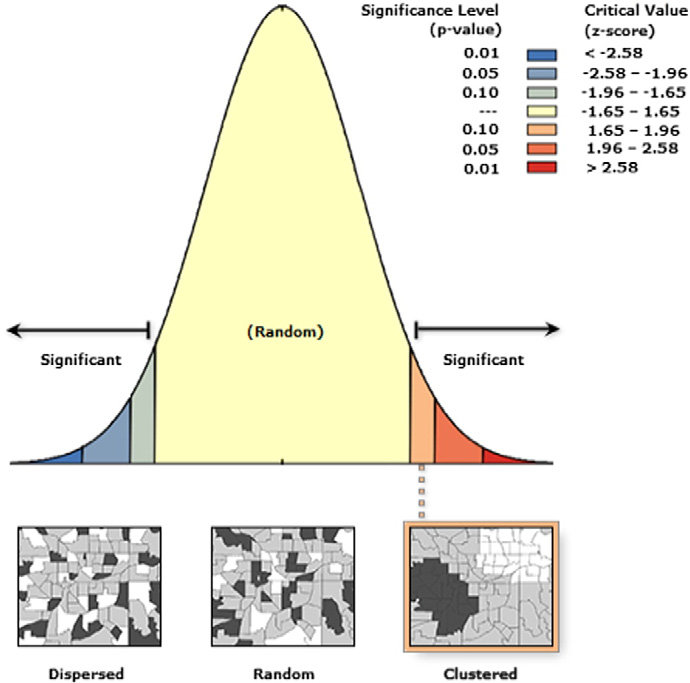
    - However, if Moran's I is positive (meaning we have like values near like values) we know that it is unlikely that this is equally present across the dataset. Some places will have less "neighbors" (near points) and others will have less like values near other like values (possibly an area where if taken alone has 0 or negative or just lower positive spatial autocorrelation?). Additionally, we might want to know where our dataset has clusters of like values in the extremes of our dataset. All of this is addressed by Getis-Ord Gi* which looks at spatial autocorrelation per neighborhood, which is what is meant by "local measure". Points will be labeled with what cluster it is in and whether it is a "hot spot" (high value cluster) or a "cold spot" (low value cluster). This can then be visualized on a map. How hot and cold spots are denoted is by how many standard deviations from the mean the spatial autocorrelation is from random per cluster. 
    
    
#### Moran's I
There are two parts to the Moran's I calculation: 
1. weights (distance based spatial weights)
    - how we define how close points are and therefore neighborhoods
2. values & spatial location (geodataframe)
    - where points are and what the important value is - in this case: parking cost

### Part 1 - Spatial Weights

We are defining how close points are by routing between them (making a skim) instead of using Euclidean Distance. While the impact is likely not huge, the boundary of water features is not included when using Euclidean distance and there are a lot of water features in and around Boston.

    a. Create Graph
    b. Find nearest node on the graph to each lot
    c. Store the relationship between nodes to lots (order is maintained)

C:\Users\matkinson.AD\Anaconda3\envs\geostat\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  This is separate from the ipykernel package so we can avoid doing imports until


id                                                         234
town                                                    BOSTON
at_3level                                                Dense
geometry     POLYGON ((-71.04474055004258 42.29763970273902...
Name: (0, 1), dtype: object
id                                                         234
town                                                    BOSTON
at_3level                                                Dense
geometry     POLYGON ((-71.06741056218544 42.39348471965923...
Name: (0, 3), dtype: object
id                                                         234
town                                                    BOSTON
at_3level                                                Dense
geometry     POLYGON ((-70.9578945218353 42.311429707701066...
Name: (0, 4), dtype: object
id                                                         234
town                                                    BOSTON
at_3level                         

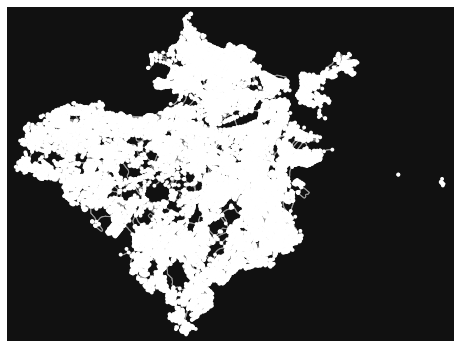

In [21]:
# Create Node/Lot Relationship Table
count = 0
allpoly = districts.dissolve().explode()
for i, row in allpoly.iterrows():
    try:
        net = ox.graph_from_polygon(row['geometry'], network_type='drive')
        if count > 0:
            full_net = nx.compose(full_net, net)
        else:
            full_net = net
        count+=1
    except:
        print(row)
#show graph
ox.plot_graph(full_net)

# reproject lots to match graph (see below)
lots84=estmonth.to_crs('EPSG: 4326')

#project graph to a GCRS as nearest_nodes uses greatest circle for distance and flat planes will give erroneous
full_net84 = ox.project_graph(full_net,to_crs={'proj':'longlat','epsg':'4326'})

# find nearest nodes to parking lots
lot_nodes = ox.nearest_nodes(full_net84, lots84.geometry.x, lots84.geometry.y)

# Create reference dict then table
estmonth['nearest_node'] = lot_nodes

### Create or Import Distance Matrix (skim) and CLean

In [22]:
# Create or Import Distance Matrix (skim)
'''
# USE ONLY IF YOU NEED A NEW DISTANCE MATRIX THIS CAN TAKE A WHILE TO RUN
# Create graph from OSM

# create origin and destination lists (pairs)
blarg = pd.DataFrame(data=None, index=lot_nodes, columns = lot_nodes)

# Create Skim - this takes about 10 hours to run.
for i in blarg.index:
    j = [i]*len(blarg.columns)
    routes = ox.shortest_path(full_net84, j, blarg.columns, weight='length')
    
    blarg[i] = routes
    
blarg

blarg.to_csv("J:\Shared drives\TMD_TSA\Data\Parking\WebScraped_ParkingCost\\routesnodes_mar16.csv")

# We think that the create skim section is fixed but unclear - if not giving distance use:
def fred(x):
    if type(x) == type([]):
        y = sum(ox.utils_graph.get_route_edge_attributes(full_net84,x,"length",'length'))
    else:
        y = x
    return y
skim = blarg.applymap(lambda x: fred(x))
skim
skim.to_csv("J:\Shared drives\TMD_TSA\Data\Parking\WebScraped_ParkingCost\\skim_mar16.csv")
'''


skim = pd.read_csv("J:\Shared drives\TMD_TSA\Data\Parking\WebScraped_ParkingCost\\skim_mar16.csv",index_col= 0 )

In [23]:
# Deal with duplicated columns/index (handled differently, but should be same)
    # Columns take .1, .2 etc suffix, Indices accept duplicates - we would like no duplicates
    # Thankfully in the skim, order should be the same.
skim = skim.set_index(skim.columns)
# Take the Inverse Distance (puts between 0 and 1) - Classic
skim_weighted = 1/skim
# If denominator was 0 (diags), set value = 0
skim_weighted = skim_weighted.applymap(lambda x: 0 if x > 1 else (0 if pd.isna(x) else x))

skim_weighted.to_csv("J:\Shared drives\TMD_TSA\Data\Parking\WebScraped_ParkingCost\\lotskim_weighted_adjusted.csv")
skim_weighted

61339810  61362200  61371587  61381868  61341689  61471576  \
61339810    0.000000  0.005715  0.000437  0.000640  0.000497  0.000467   
61362200    0.001952  0.000000  0.000434  0.000635  0.000493  0.000464   
61371587    0.000386  0.000440  0.000000  0.000978  0.001722  0.002412   
61381868    0.000484  0.000637  0.000934  0.000000  0.001259  0.001321   
61341689    0.000498  0.000591  0.001000  0.000880  0.000000  0.001158   
...              ...       ...       ...       ...       ...       ...   
3189285908  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
67491506    0.000068  0.000069  0.000075  0.000071  0.000075  0.000075   
67433782    0.000081  0.000082  0.000085  0.000079  0.000084  0.000083   
67467286    0.000063  0.000064  0.000066  0.000062  0.000065  0.000065   
67534816    0.000066  0.000068  0.000069  0.000066  0.000069  0.000068   

            61349099  61341290  61353360  61341258  ...  67456432  67441522  \
61339810    0.000807  0.000476  0.000645  0.000482  ...  0.000055  0.000065   
61362200    0.000724  0.000473  0.000640  0.000479  ...  0.000056  0.000065   
61371587    0.000379  0.000523  0.000589  0.001952  ...  0.000056  0.000065   
61381868    0.000620  0.001123  0.000562  0.001170  ...  0.000055  0.000064   
61341689    0.000461  0.000493  0.000809  0.001054  ...  0.000058  0.000067   
...              ...       ...       ...       ...  ...       ...       ...   
3189285908  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
67491506    0.000065  0.000067  0.000077  0.000074  ...  0.000133  0.000187   
67433782    0.000075  0.000074  0.000089  0.000083  ...  0.000175  0.000300   
67467286    0.000060  0.000059  0.000068  0.000064  ...  0.000266  0.000399   
67534816    0.000063  0.000062  0.000072  0.000068  ...  0.000328  0.001192   

            67435219  1352871016  67455990  3189285908  67491506  67433782  \
61339810    0.000059    0.000063  0.000057    0.000054  0.000068  0.000081   
61362200    0.000060    0.000063  0.000058    0.000054  0.000069  0.000082   
61371587    0.000060    0.000066  0.000058    0.000056  0.000075  0.000082   
61381868    0.000059    0.000065  0.000057    0.000055  0.000072  0.000080   
61341689    0.000062    0.000068  0.000060    0.000057  0.000076  0.000086   
...              ...         ...       ...         ...       ...       ...   
3189285908  0.000000    0.000000  0.000000    0.000000  0.000000  0.000000   
67491506    0.000158    0.000341  0.000155    0.000173  0.000000  0.000205   
67433782    0.000212    0.000207  0.000189    0.000154  0.000205  0.000000   
67467286    0.000350    0.000214  0.000273    0.000176  0.000151  0.000289   
67534816    0.000466    0.000333  0.000356    0.000250  0.000199  0.000375   

            67467286  67534816  
61339810    0.000063  0.000066  
61362200    0.000064  0.000066  
61371587    0.000064  0.000067  
61381868    0.000063  0.000065  
61341689    0.000066  0.000069  
...              ...       ...  
3189285908  0.000000  0.000000  
67491506    0.000151  0.000193  
67433782    0.000289  0.000355  
67467286    0.000000  0.000599  
67534816    0.000599  0.000000  

[422 rows x 422 columns]

### FILTER OUT MISSING DATA

While lots with no parking information were filtered out originally, we have seen above that not all records have all three types of rate data. Moran's I requires that no missing data is input - so for each type of rate we need to filter out NAs and the corresponding paths in the skim.

In [24]:
# make sure the repeated nodes are differentiated (like in skim) (hopefully same order)
estmonth['cols']=skim_weighted.columns

def filter_skim(rates2):
    #for monthly to start - drop NA lots for Monthly by columns and rows
    b = set(pd.Series(skim_weighted.index.astype(str)).tolist())
    c = set(estmonth[estmonth[rates2].isna()]['cols'].astype(str).tolist())

    # drop all columns and rows that involve parking lots with null Monthly rate estimated values
    skim_filtered = skim_weighted.drop(c&b, axis = 0)
    skim_filtered2 = skim_filtered.drop(c&b, axis = 1)
    
    return skim_filtered2


In [25]:
# Monthly Filtered Skim
skim_weighted_monthly = filter_skim("Monthly_Rate_wEst2")

# Daily Filtered Skim
skim_weighted_daily = filter_skim("Daily_Rate_wEst2")

# Hourly Filtered Skim
skim_weighted_hourly = filter_skim("Hourly_Rate_wEst2")

skim_weighted_monthly


61339810  61362200  61371587  61381868  61341689  61471576  \
61339810    0.000000  0.005715  0.000437  0.000640  0.000497  0.000467   
61362200    0.001952  0.000000  0.000434  0.000635  0.000493  0.000464   
61371587    0.000386  0.000440  0.000000  0.000978  0.001722  0.002412   
61381868    0.000484  0.000637  0.000934  0.000000  0.001259  0.001321   
61341689    0.000498  0.000591  0.001000  0.000880  0.000000  0.001158   
...              ...       ...       ...       ...       ...       ...   
3189285908  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
67491506    0.000068  0.000069  0.000075  0.000071  0.000075  0.000075   
67433782    0.000081  0.000082  0.000085  0.000079  0.000084  0.000083   
67467286    0.000063  0.000064  0.000066  0.000062  0.000065  0.000065   
67534816    0.000066  0.000068  0.000069  0.000066  0.000069  0.000068   

            61349099  61341290  61353360  61341258  ...  67456432  67441522  \
61339810    0.000807  0.000476  0.000645  0.000482  ...  0.000055  0.000065   
61362200    0.000724  0.000473  0.000640  0.000479  ...  0.000056  0.000065   
61371587    0.000379  0.000523  0.000589  0.001952  ...  0.000056  0.000065   
61381868    0.000620  0.001123  0.000562  0.001170  ...  0.000055  0.000064   
61341689    0.000461  0.000493  0.000809  0.001054  ...  0.000058  0.000067   
...              ...       ...       ...       ...  ...       ...       ...   
3189285908  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
67491506    0.000065  0.000067  0.000077  0.000074  ...  0.000133  0.000187   
67433782    0.000075  0.000074  0.000089  0.000083  ...  0.000175  0.000300   
67467286    0.000060  0.000059  0.000068  0.000064  ...  0.000266  0.000399   
67534816    0.000063  0.000062  0.000072  0.000068  ...  0.000328  0.001192   

            67435219  1352871016  67455990  3189285908  67491506  67433782  \
61339810    0.000059    0.000063  0.000057    0.000054  0.000068  0.000081   
61362200    0.000060    0.000063  0.000058    0.000054  0.000069  0.000082   
61371587    0.000060    0.000066  0.000058    0.000056  0.000075  0.000082   
61381868    0.000059    0.000065  0.000057    0.000055  0.000072  0.000080   
61341689    0.000062    0.000068  0.000060    0.000057  0.000076  0.000086   
...              ...         ...       ...         ...       ...       ...   
3189285908  0.000000    0.000000  0.000000    0.000000  0.000000  0.000000   
67491506    0.000158    0.000341  0.000155    0.000173  0.000000  0.000205   
67433782    0.000212    0.000207  0.000189    0.000154  0.000205  0.000000   
67467286    0.000350    0.000214  0.000273    0.000176  0.000151  0.000289   
67534816    0.000466    0.000333  0.000356    0.000250  0.000199  0.000375   

            67467286  67534816  
61339810    0.000063  0.000066  
61362200    0.000064  0.000066  
61371587    0.000064  0.000067  
61381868    0.000063  0.000065  
61341689    0.000066  0.000069  
...              ...       ...  
3189285908  0.000000  0.000000  
67491506    0.000151  0.000193  
67433782    0.000289  0.000355  
67467286    0.000000  0.000599  
67534816    0.000599  0.000000  

[422 rows x 422 columns]

### Create Spatial Weights Objects (From Skim)

Move through Scipy Sparse Distance Matrix

In [26]:
def make_sw(filtered_weighted_skim):
    '''Create Spatial Weights from Sparse Distance Matrix'''
    sparse = scipy.sparse.csr_matrix(filtered_weighted_skim)
    w = WSP(sparse)
    weights = w.to_W()
    return weights

In [27]:
# Monthly Spatial Weights
monthly_weights = make_sw(skim_weighted_monthly)
# Daily Spatial Weights
daily_weights = make_sw(skim_weighted_daily)
# Hourly Spatial Weights
hourly_weights = make_sw(skim_weighted_hourly)

monthly_weights.full() # show inside of weights and what lots are islands!

C:\Users\matkinson.AD\Anaconda3\envs\geostat\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There are 3 islands with ids: 273, 362, 417.
  warnings.warn(message)


(array([[0.00000000e+00, 5.71487353e-03, 4.36756177e-04, ...,
         8.11320320e-05, 6.33652606e-05, 6.60353773e-05],
        [1.95155461e-03, 0.00000000e+00, 4.34336375e-04, ...,
         8.16244173e-05, 6.36652086e-05, 6.63612016e-05],
        [3.86159577e-04, 4.39762827e-04, 0.00000000e+00, ...,
         8.24966659e-05, 6.41946093e-05, 6.69365907e-05],
        ...,
        [8.06575136e-05, 8.23962952e-05, 8.52300064e-05, ...,
         0.00000000e+00, 2.89357713e-04, 3.54885532e-04],
        [6.30754412e-05, 6.41338170e-05, 6.58376088e-05, ...,
         2.89357713e-04, 0.00000000e+00, 5.98951954e-04],
        [6.63926245e-05, 6.75662847e-05, 6.94600247e-05, ...,
         3.75401727e-04, 5.98951954e-04, 0.00000000e+00]]),
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,

## Run Moran's I

As a note - Moran's I does not accept infinite or NA (missing) rates - the column containing estimated rates must be filtered/edited to compensate for these conditions. This filtering has already been done to the spatial weights through filtering of the skim. Due to every index/column name set having the same order, the spatial weight will match up with the order of lots in the rates column.

In [28]:
# Moran's I 
# FYI - Issue with this is that 0 is a real value unlike NA, so need to rid of all NAs (also these points from weights)
# Also - rowsum

# Monthly
mimr = Moran(estmonth['Monthly_Rate_wEst2'].round(0).apply(lambda x: 0 if x > 1000 else x).dropna(),  monthly_weights, transformation='r')
# Daily
midr = Moran(estmonth['Daily_Rate_wEst2'].round(0).apply(lambda x: 0 if x > 1000 else x).dropna(),  daily_weights, transformation='r')
# Hourly
mihr = Moran(estmonth['Hourly_Rate_wEst2'].round(0).apply(lambda x: 0 if x > 1000 else x).dropna(),  hourly_weights, transformation='r')

('WARNING: ', 273, ' is an island (no neighbors)')
('WARNING: ', 362, ' is an island (no neighbors)')
('WARNING: ', 417, ' is an island (no neighbors)')
('WARNING: ', 273, ' is an island (no neighbors)')
('WARNING: ', 362, ' is an island (no neighbors)')
('WARNING: ', 417, ' is an island (no neighbors)')
('WARNING: ', 273, ' is an island (no neighbors)')
('WARNING: ', 362, ' is an island (no neighbors)')
('WARNING: ', 417, ' is an island (no neighbors)')


In [29]:
# Results Table

mitab = pd.DataFrame({'Monthly': {'p_value': mimr.p_norm, 'Z_Score': mimr.z_norm},
                     'Daily': {'p_value': midr.p_norm, 'Z_Score': midr.z_norm},
                     'Hourly': {'p_value': mihr.p_norm, 'Z_Score': mihr.z_norm}})

mitab

Monthly      Daily     Hourly
p_value   0.000000   0.000000   0.000000
Z_Score  15.352962  15.064677  17.375843

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.13', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.13)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

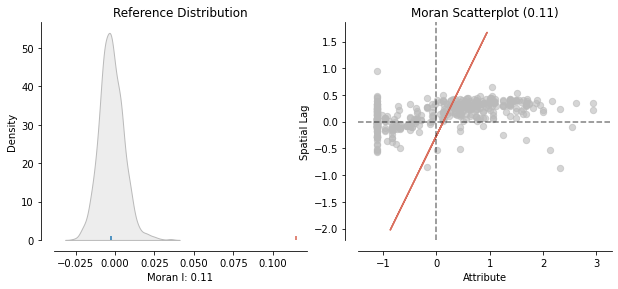

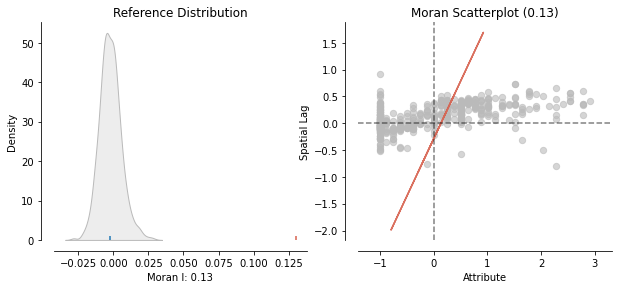

In [30]:
# Visual Summaries of Moran's I Results
plot_moran(mimr, zstandard=True, figsize=(10,4))
plot_moran(midr, zstandard=True, figsize=(10,4))
plot_moran(mihr, zstandard=True, figsize=(10,4))

## What we know so far:

The data is positively spatially autocorrelated - meaning that there is a less than 1% likelihood that this value and spatial clustering pattern was created randomly and that like values are near other like values, globally.

Since we do have positive spatial autocorrelation globally, we can run a local spatial autocorrelation algorithm. In this case - I am using Getis Ord GI* (pronounced Getis Ord GEE EYE STAR), also called Hot-Spot Analysis to see if there are clusters of points with similar values that are either high or low in terms of the range of values. In this algorithm, clusters of 'medium' e.g. value clusters that are not high or low in a statistically significant way. Getis Ord Gi* is (from my experience) the most common local spatial autocorrelation algorithm, but there are more local algorithms that are used than global as Moran's I is a default.

See the following explanation of Getis Ord Gi* from Esri - https://pro.arcgis.com/en/pro-app/2.8/tool-reference/spatial-statistics/h-how-hot-spot-analysis-getis-ord-gi-spatial-stati.htm

"The Hot Spot Analysis tool calculates the Getis-Ord Gi* statistic (pronounced G-i-star) for each feature in a dataset. The resultant z-scores and p-values tell you where features with either high or low values cluster spatially. This tool works by looking at each feature within the context of neighboring features. A feature with a high value is interesting but may not be a statistically significant hot spot. To be a statistically significant hot spot, a feature will have a high value and be surrounded by other features with high values as well. The local sum for a feature and its neighbors is compared proportionally to the sum of all features; when the local sum is very different from the expected local sum, and when that difference is too large to be the result of random chance, a statistically significant z-score results. When the FDR correction is applied, statistical significance is adjusted to account for multiple testing and spatial dependency."

In [31]:
# Export estmonth as geojson for use in ArcPro and QGIS for Local Moran's I and Getis Ord Gi*
estmonth[["IN_SingleL","geometry","USER_month","USER_lot_u","IN_SingleLine","USER_lot_url","attr_dist","id",
         "town","at_3level","Monthly_to_Daily","Est_Monthly","Monthly_Rate_wEst","Daily_to_Hourly","Est_Daily",
         "Daily_Rate_wEst","Monthly_to_Hourly","Est_Hourly","Hourly_Rate_wEst","Est_Monthly2","Monthly_Rate_wEst2",
         "Est_Daily2","Daily_Rate_wEst2","Est_Hourly2",
         "Hourly_Rate_wEst2"]].to_file("J:\Shared drives\TMD_TSA\Data\Parking\WebScraped_ParkingCost\estmonth_April14.geojson")  

## Results of Local Spatial Autocorrelation

Due to a lack of experience with running spatial autocorrelation in python - Getis Ord Gi* was run in QGIS with the following specifications:
1. KNN = 8 (all neighborhoods have 8 neighbors)
3. Row Standardization
5. Run on Rate column with estimates (nulls)

The results show that for all three rate types (hourly, daily, monthly) there is significant local spatial autocorrelation with high clusters downtown and cold clusters (though more spread out) further out. Given this information - we aggregate the lots rates data to TAZs using the 8 nearest neighbors and distances from the TAZ centroid (euclidean) to create a weighted average. The weights are created for each OD pair where the weight is 1/(distance)^2 (squared)

To identify outliers within clusters to smooth the weighted averages assigned to TAZs, Local Moran's I was run with the same specifications as Getis Ord Gi* above. The results are below. Please note that the legends for the maps are the same as for the graphs.


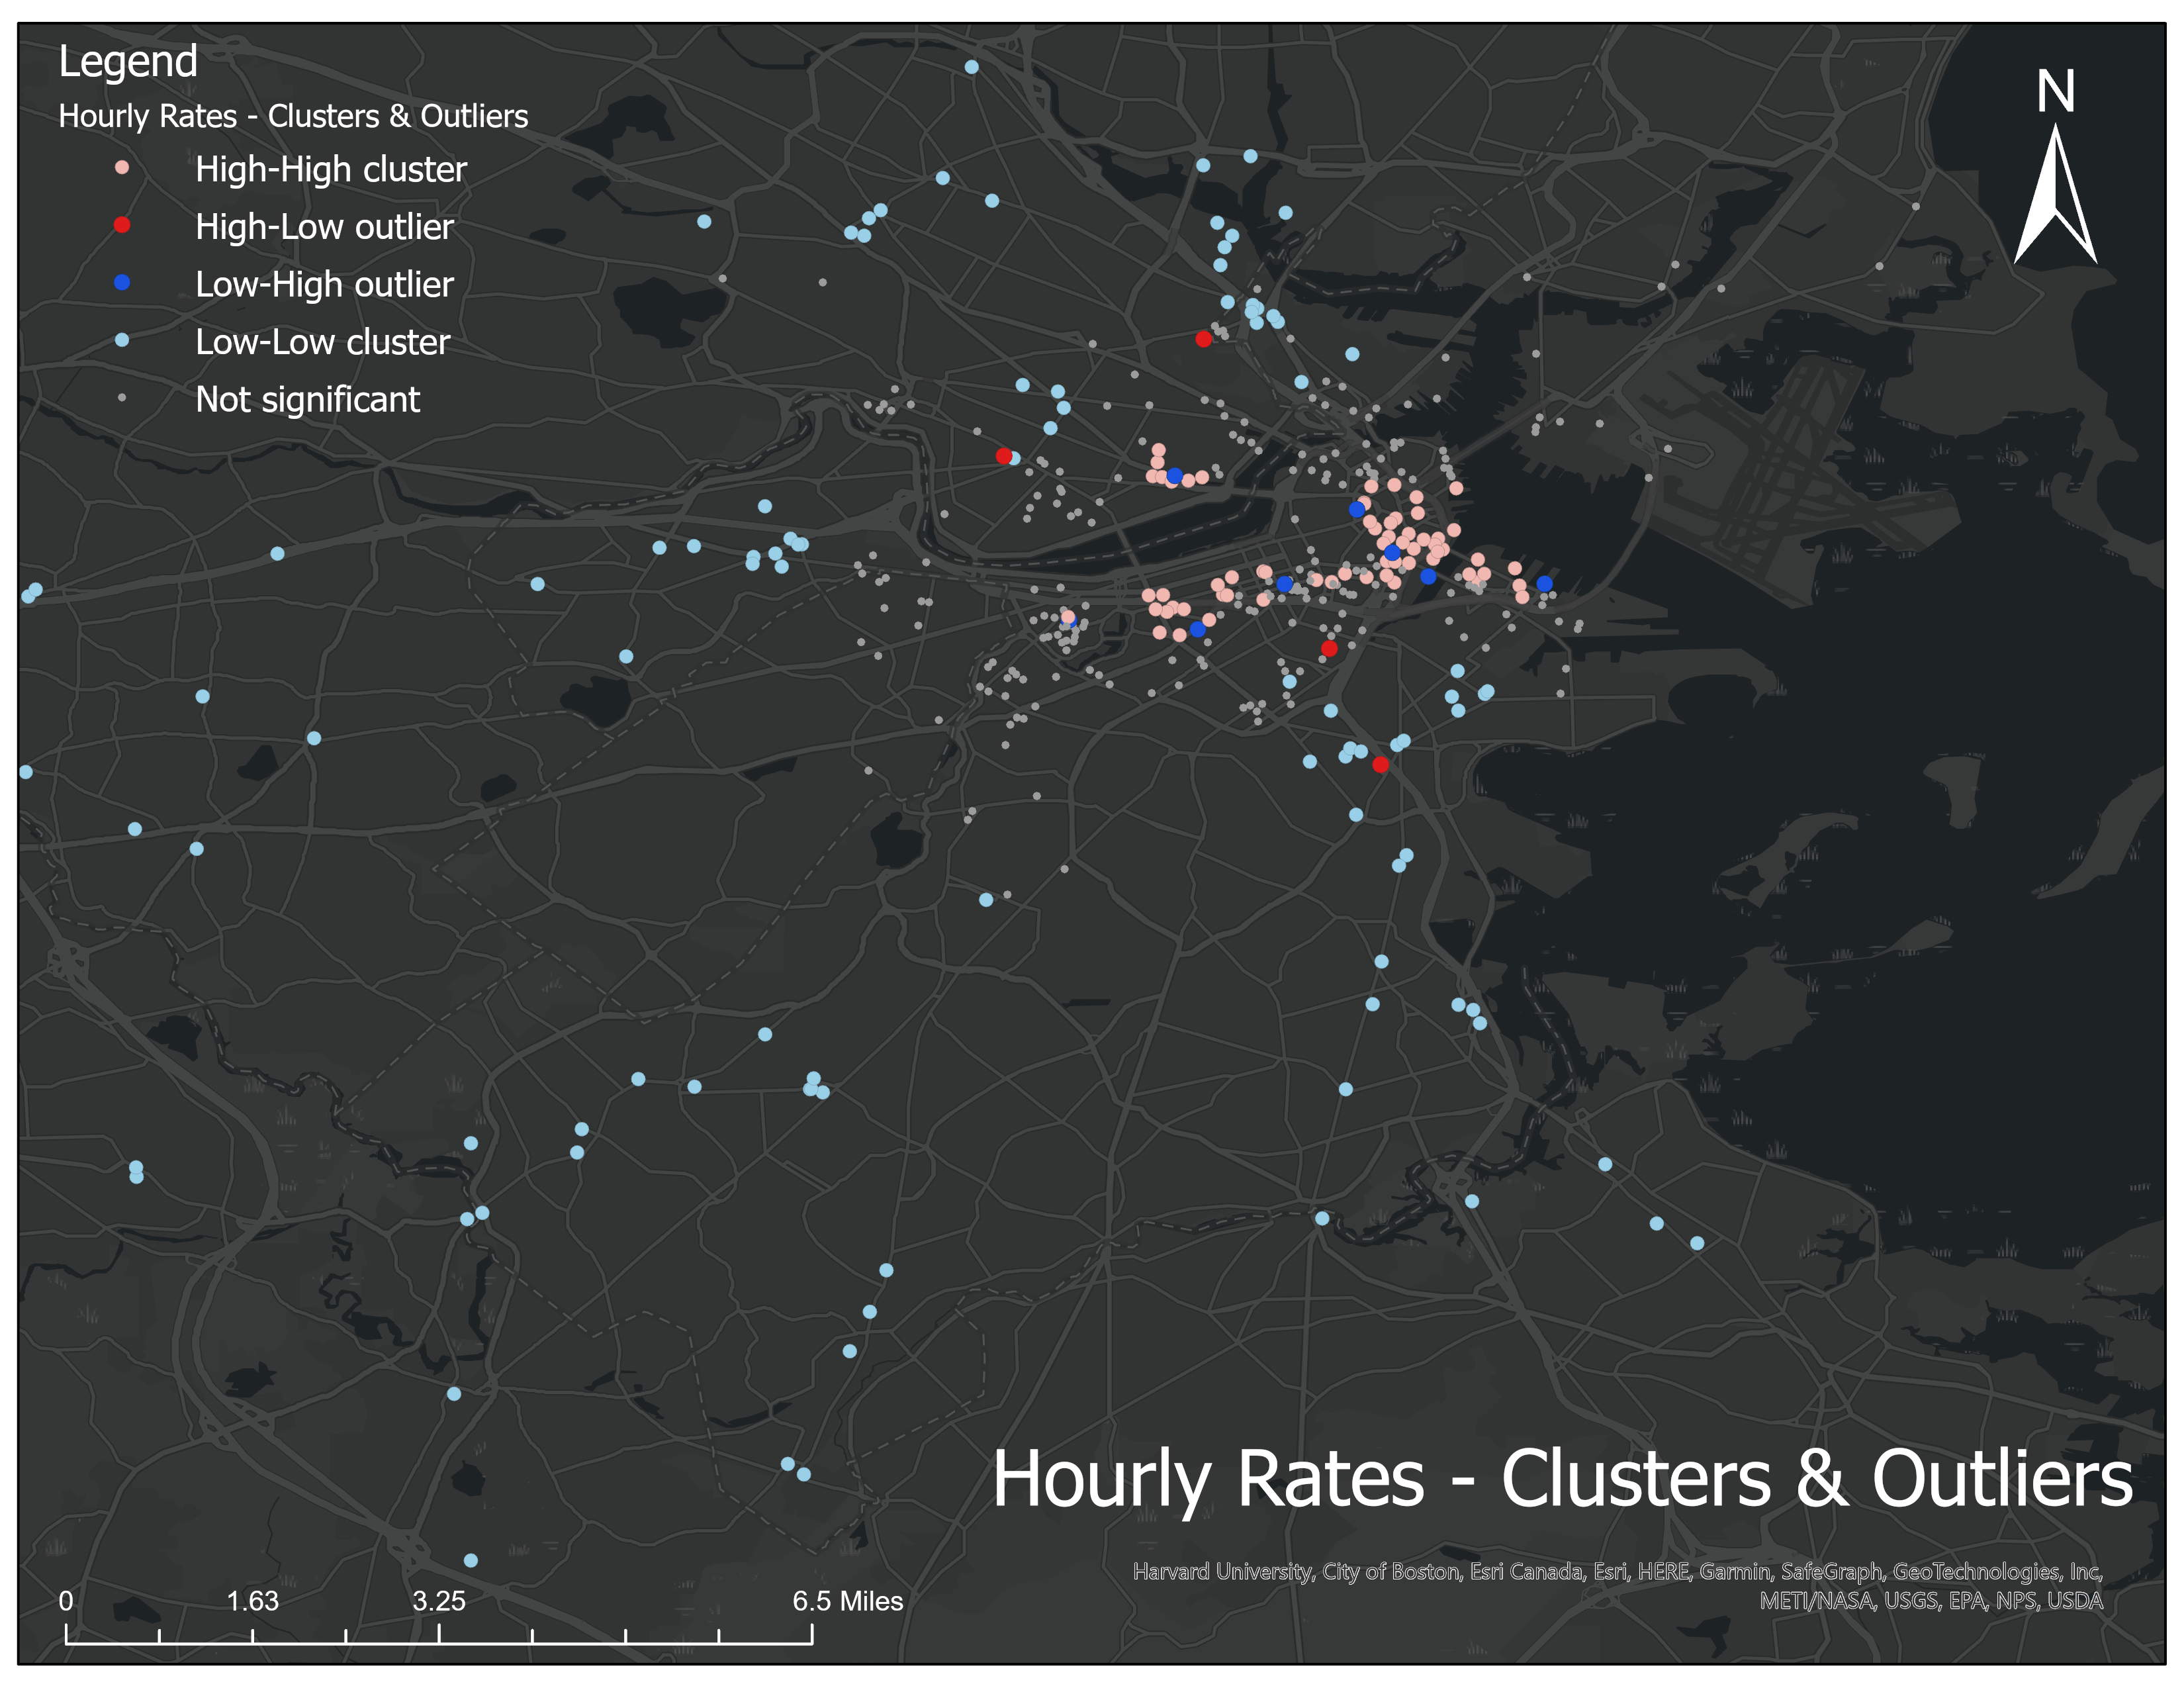

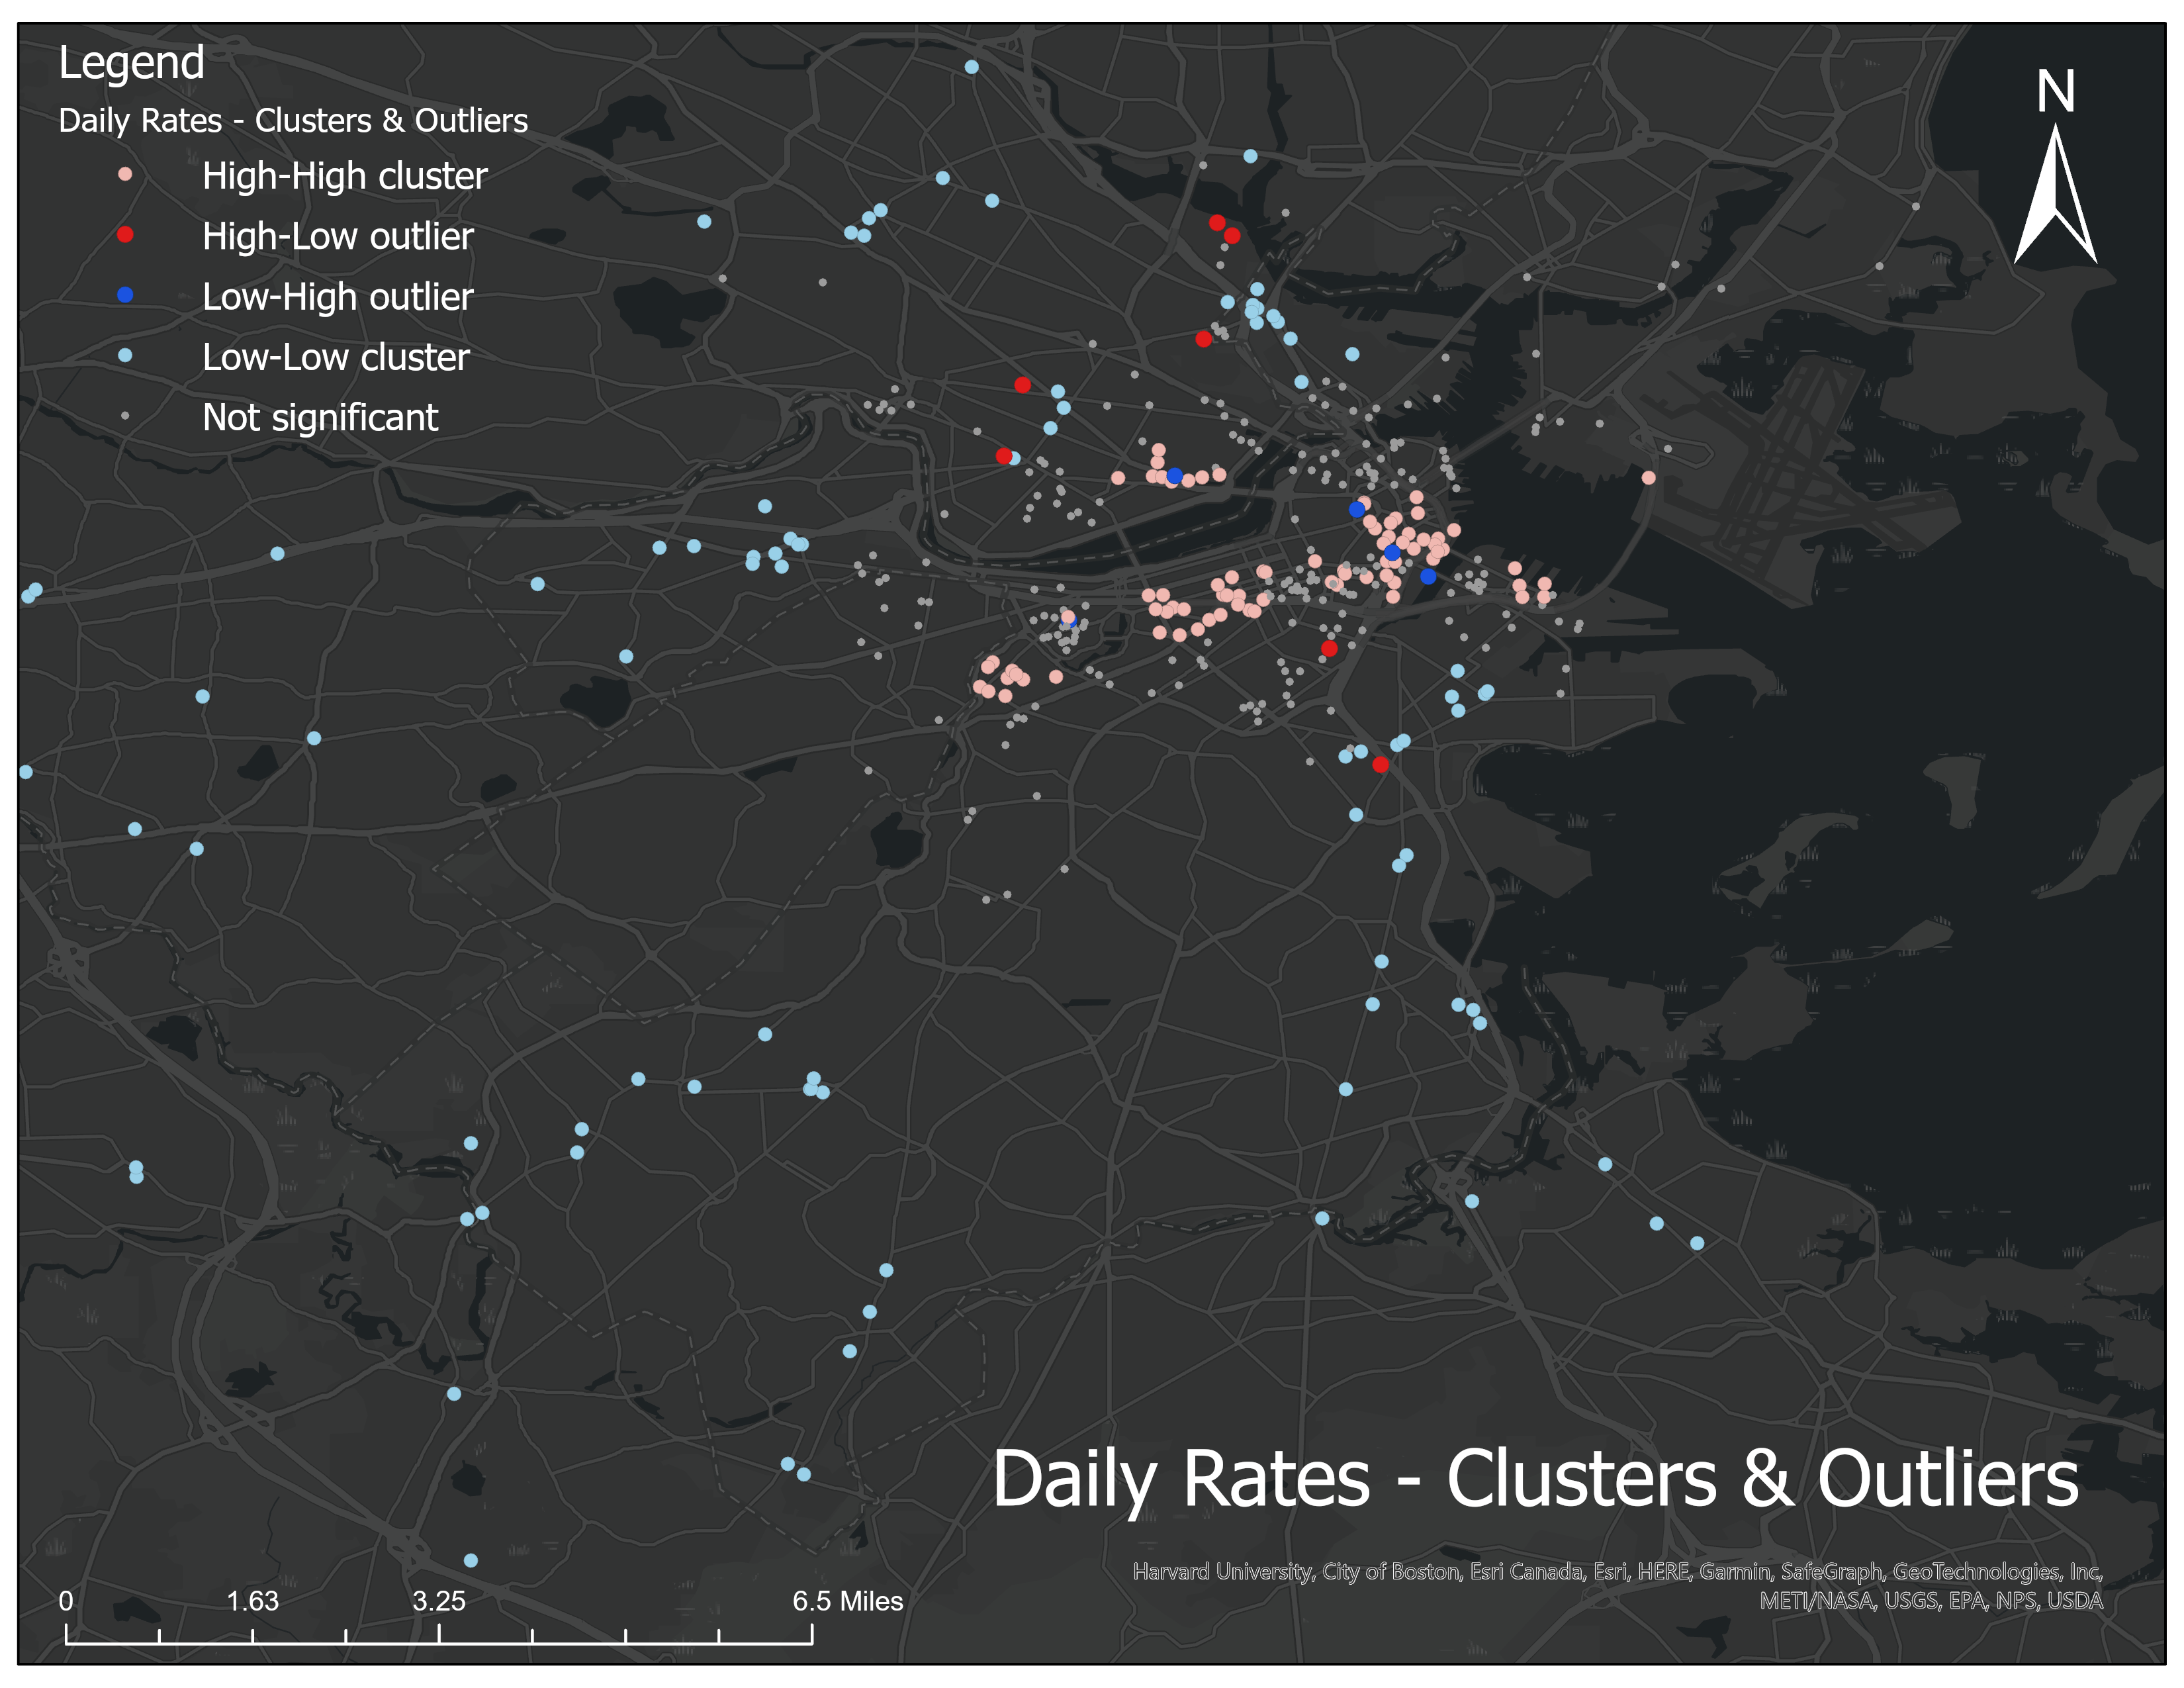

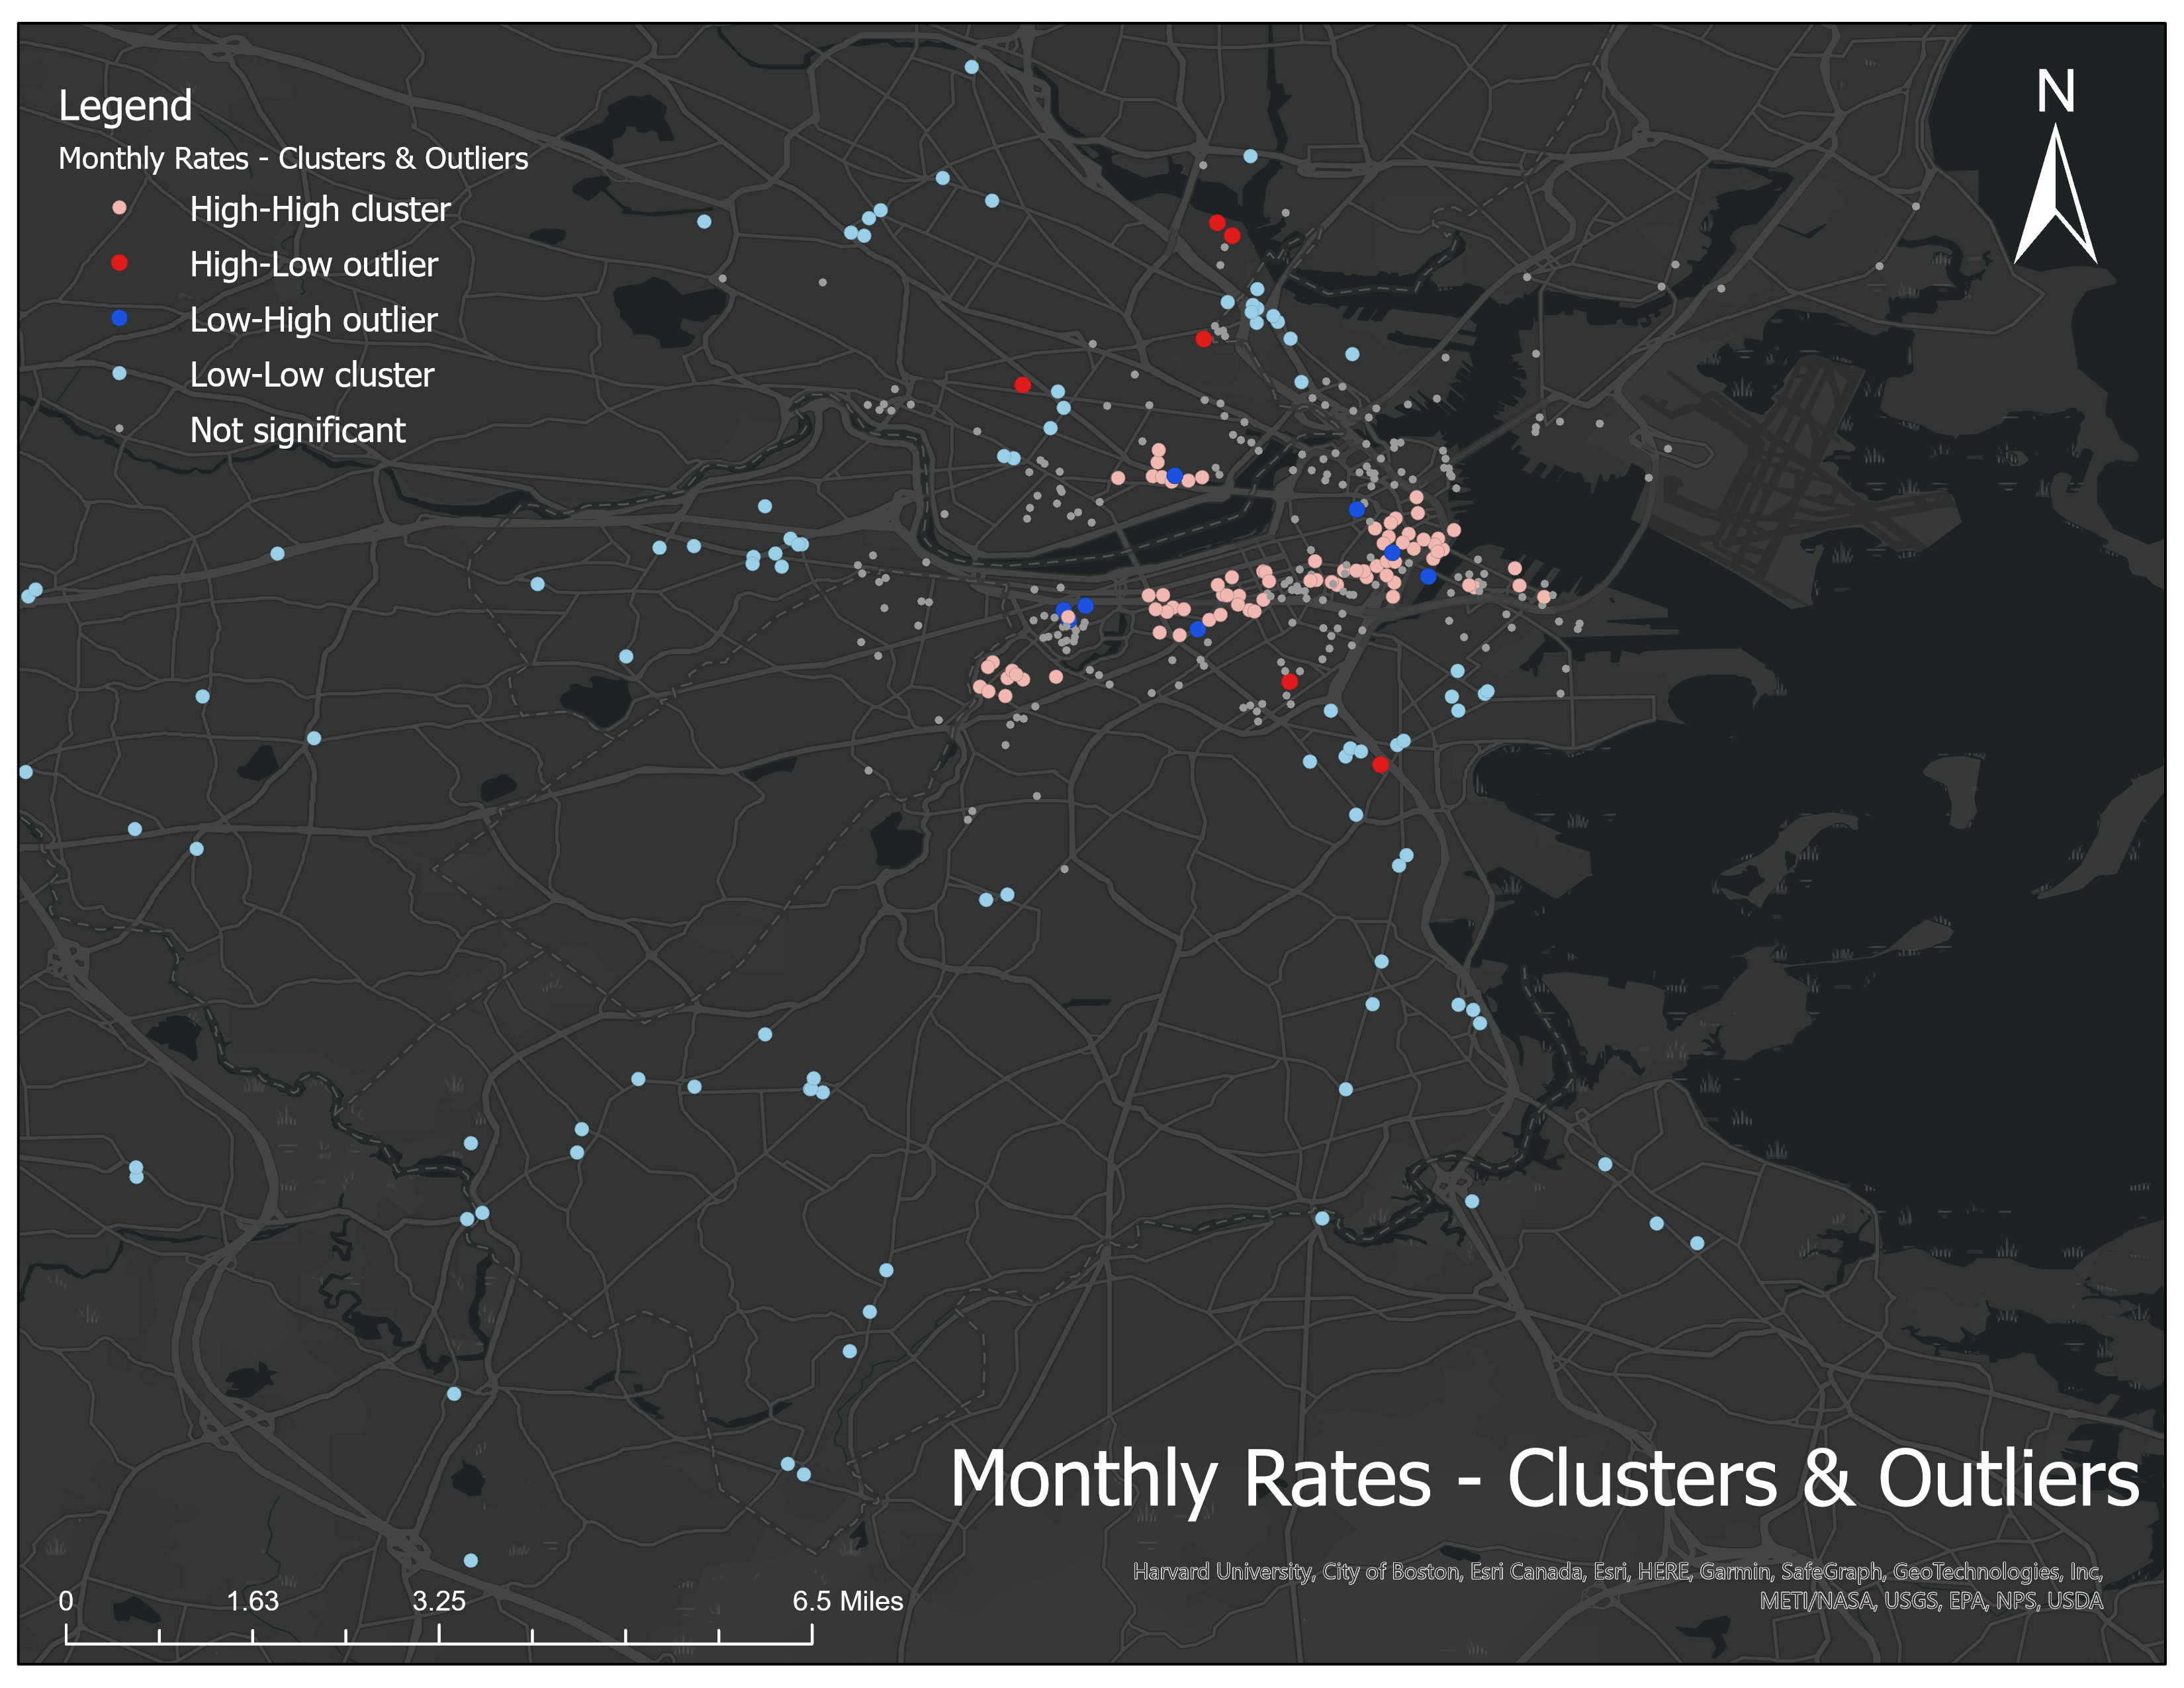

In [130]:
# IMPORT THE RESULTS OF LOCAL MORAN's I
estmonthLM = gpd.read_file("J:\Shared drives\TMD_TSA\Data\Parking\WebScraped_ParkingCost\estmonth_April14_HR_DR_MR_LM.geojson")
estmonth = estmonth.to_crs(estmonthLM.crs)
estmonth = estmonth.drop(columns=["index_right"])
estmonth = estmonth.sjoin_nearest(estmonthLM[["COType_HR","COType_DR","COType_MR","geometry"]], how="left")

In [131]:
# 1 and 13 are very close to each other (see index_right) removing them so can filter later
estmonth = estmonth[~estmonth.index.duplicated(keep='first')]
estmonth

IN_SingleL                       geometry  \
0           208 Friend St Boston, MA 02114, US  POINT (236180.254 901600.497)   
1         21 Lancaster St Boston, MA 02114, US  POINT (236067.880 901602.725)   
2               28 Ash St Boston, MA 02111, US  POINT (235976.290 899891.274)   
3             33 Essex St Boston, MA 02111, US  POINT (236587.900 900337.024)   
4          47 Lagrange St Boston, MA 02116, US  POINT (235915.024 900228.046)   
..                                         ...                            ...   
459   Yankee Division Hwy Newton, MA 02462, US  POINT (220188.936 897827.030)   
460  98-100 Winchester St Newton, MA 02461, US  POINT (224019.453 896285.304)   
461     612 Washington St Newton, MA 02458, US  POINT (224844.388 900417.628)   
462         591 Moody St Waltham, MA 02453, US  POINT (221551.355 901772.055)   
463            102 Elm St Newton, MA 02465, US  POINT (222335.908 899906.734)   

             USER_month                          USER_lot_u  \
0    Mon-Fri:  6am-12am    https://www.parkme.com/lot/15284   
1    Mon-Fri:  6am-12am    https://www.parkme.com/lot/15286   
2    Mon-Sun:  24 Hours    https://www.parkme.com/lot/32124   
3     Mon-Fri:  6am-2am    https://www.parkme.com/lot/15268   
4    Mon-Sun:  24 Hours    https://www.parkme.com/lot/24171   
..                  ...                                 ...   
459  Mon-Sun:  24 Hours   https://www.parkme.com/lot/340721   
460                None  https://www.parkme.com/lot/1183409   
461                None  https://www.parkme.com/lot/1183400   
462                None  https://www.parkme.com/lot/1184561   
463  Mon-Sun:  24 Hours   https://www.parkme.com/lot/106296   

                                  IN_SingleLine  \
0           208 Friend St Boston, MA 02114, US    
1         21 Lancaster St Boston, MA 02114, US    
2               28 Ash St Boston, MA 02111, US    
3             33 Essex St Boston, MA 02111, US    
4          47 Lagrange St Boston, MA 02116, US    
..                                          ...   
459   Yankee Division Hwy Newton, MA 02462, US    
460  98-100 Winchester St Newton, MA 02461, US    
461     612 Washington St Newton, MA 02458, US    
462         591 Moody St Waltham, MA 02453, US    
463            102 Elm St Newton, MA 02465, US    

                           USER_lot_url  MR    DR    HR         attr_dist  \
0      https://www.parkme.com/lot/15284 NaN  25.0  10.0   West End, Dense   
1      https://www.parkme.com/lot/15286 NaN  25.0  10.0   West End, Dense   
2      https://www.parkme.com/lot/32124 NaN  23.0  10.0  Chinatown, Dense   
3      https://www.parkme.com/lot/15268 NaN  30.0  10.0   Downtown, Dense   
4      https://www.parkme.com/lot/24171 NaN  25.0  10.0   Downtown, Dense   
..                                  ...  ..   ...   ...               ...   
459   https://www.parkme.com/lot/340721 NaN   NaN   0.0     NEWTON, Urban   
460  https://www.parkme.com/lot/1183409 NaN   NaN   0.0     NEWTON, Urban   
461  https://www.parkme.com/lot/1183400 NaN   NaN   0.0     NEWTON, Urban   
462  https://www.parkme.com/lot/1184561 NaN   NaN   0.0               NaN   
463   https://www.parkme.com/lot/106296 NaN   NaN   0.0     NEWTON, Urban   

     ...  COType_HR_left COType_DR_left COType_MR_left  COType_HR_right  \
0    ...                                                                  
1    ...                                                                  
2    ...                                                                  
3    ...              HH                                             HH   
4    ...                             HH             HH                    
..   ...             ...            ...            ...              ...   
459  ...                             LL             LL                    
460  ...              LL             LL             LL               LL   
461  ...              LL             LL             LL               LL   
462  ...          

# Aggregate Rates to TAZs



In [132]:
# get euclidean distance matrix from TAZ centroids to lots
# also reproject to Mass State Plane (meters) so that distance is correct
rdg83 = alltazs.to_crs("EPSG:26986").set_index("id") # TAZ ids are now the column names
estmonth83 = estmonth.to_crs("EPSG:26986") # index is the row name

eucdist = estmonth83.centroid.geometry.apply(lambda g: rdg83.distance(g))
eucdist

id         4398          2571          2669          4392          2641    \
0    45928.829127  41516.655839  42966.842194  46500.307105  40755.093447   
1    45962.115484  41544.814292  43004.650891  46535.205410  40834.239528   
2    44347.346792  39904.563486  41416.543632  44929.365120  39679.461879   
3    44601.941619  40193.436029  41639.303607  45172.906770  39562.894024   
4    44687.411303  40246.102346  41754.517184  45268.789941  39959.741999   
..            ...           ...           ...           ...           ...   
459  49159.386965  44507.053211  47364.831010  50283.793992  51050.432101   
460  45828.987641  41146.317955  43814.926989  46839.634026  46969.419955   
461  49056.053200  44357.317642  46775.301603  49931.610270  48556.674496   
462  51814.697147  47126.616708  49719.518271  52790.094128  52027.207024   
463  49806.101434  45119.998524  47740.333486  50794.724025  50329.445292   

id         2643          2666          2665          2675          1961    \
0    43123.666548  46024.804174  47193.078366  49787.478212  47520.427936   
1    43206.279729  46101.461003  47268.911265  49855.825625  47566.372839   
2    42094.828106  44905.488025  46058.262812  48544.220294  49156.806618   
3    41958.790953  44814.584813  45977.331104  48529.426482  48498.532904   
4    42370.114578  45192.453722  46347.748265  48848.539162  48876.389493   
..            ...           ...           ...           ...           ...   
459  53641.852487  55774.446189  56752.536066  58194.005667  59159.159753   
460  49555.323643  51731.106173  52723.081199  54254.761818  58168.224268   
461  51096.855405  53504.580944  54555.455305  56400.872281  54300.705270   
462  54577.239586  56937.630404  57974.702161  59730.007229  55222.221344   
463  52892.391666  55193.071394  56215.610287  57897.248597  56201.874447   

id   ...        4788          4789          4790          4791    \
0    ...  75083.209682  81375.846065  79990.035073  79267.962784   
1    ...  75185.545443  81480.543888  80093.481585  79370.685403   
2    ...  74547.006244  80927.771544  79493.248074  78744.651656   
3    ...  74176.248206  80522.444603  79106.935186  78368.909725   
4    ...  74742.094882  81107.736889  79681.675723  78937.651619   
..   ...           ...           ...           ...           ...   
459  ...  88474.827145  95194.762407  93569.207298  92711.770182   
460  ...  84351.393318  91083.617044  89449.983994  88589.133427   
461  ...  85005.967337  91559.133786  90029.699340  89225.780946   
462  ...  88566.342512  95114.224697  93588.646352  92785.912874   
463  ...  87161.885415  93771.833447  92209.756516  91387.401037   

id         4792           4793           4795          4794          209094  \
0    79496.727849   88010.621330   91022.922601  79579.919283  83173.963586   
1    79599.065165   88114.041067   91124.554986  79683.013745  83092.713907   
2    78959.611633   87511.313250   90459.303330  79070.104968  81875.666230   
3    78589.464226   87126.374508   90100.506869  78688.961881  82628.801729   
4    79154.999539   87700.401799   90659.542714  79260.779847  82054.777048   
..            ...            ...            ...           ...           ...   
459  92865.689894  101542.132687  104193.241670  93093.289247  69307.840181   
460  88741.419406   97420.414863  100065.169914  88972.316767  70751.695911   
461  89409.991166   98032.400666  100832.381796  89579.784797  74333.458250   
462  92970.495483  101591.913861  104392.885948  93139.392264  73200.759647   
463  91561.237449  100203.932496  102953.052390  91750.894622  72285.534641   

id         209004  
0    85633.009407  
1    85654.732927  
2    87346.764544  
3    86783.860779  
4    87030.496396  
..            ...  
459  93889.916908  
460  94023.479420  
461  89847.582872  
462  89719.709532  
463  91180.227573  

[422 rows x 5839 columns]

In [133]:
# convert to miles
eucdistmi = eucdist/1609.34
eucdistmi

id      4398       2571       2669       4392       2641       2643    \
0    28.538922  25.797318  26.698424  28.894023  25.324104  26.795871   
1    28.559605  25.814815  26.721918  28.915708  25.373283  26.847204   
2    27.556232  24.795608  25.735111  27.917883  24.655736  26.156579   
3    27.714431  24.975105  25.873528  28.069213  24.583304  26.072049   
4    27.767539  25.007831  25.945119  28.128792  24.829894  26.327634   
..         ...        ...        ...        ...        ...        ...   
459  30.546303  27.655469  29.431215  31.244979  31.721347  33.331585   
460  28.476883  25.567200  27.225401  29.104872  29.185517  30.792327   
461  30.482094  27.562428  29.064897  31.026141  30.171794  31.750193   
462  32.196240  29.283195  30.894353  32.802325  32.328288  33.912809   
463  30.948154  28.036337  29.664542  31.562457  31.273345  32.865890   

id      2666       2665       2675       1961    ...     4788       4789    \
0    28.598559  29.324492  30.936582  29.527898  ...  46.654659  50.564732   
1    28.646191  29.371613  30.979051  29.556447  ...  46.718248  50.629789   
2    27.903046  28.619349  30.164055  30.544699  ...  46.321477  50.286311   
3    27.846561  28.569060  30.154863  30.135666  ...  46.091098  50.034452   
4    28.081359  28.799227  30.353150  30.370456  ...  46.442700  50.398136   
..         ...        ...        ...        ...  ...        ...        ...   
459  34.656720  35.264479  36.160169  36.759889  ...  54.975845  59.151430   
460  32.144299  32.760685  33.712430  36.144149  ...  52.413656  56.596876   
461  33.246288  33.899273  35.045964  33.740978  ...  52.820391  56.892350   
462  35.379491  36.023899  37.114598  34.313583  ...  55.032711  59.101386   
463  34.295470  34.930848  35.975772  34.922313  ...  54.160019  58.267261   

id      4790       4791       4792       4793       4795       4794    \
0    49.703627  49.254951  49.397099  54.687401  56.559163  49.448792   
1    49.767906  49.318780  49.460689  54.751663  56.622314  49.512852   
2    49.394937  48.929780  49.063350  54.377144  56.208945  49.132008   
3    49.154893  48.696304  48.833350  54.137954  55.985999  48.895176   
4    49.512021  49.049705  49.184759  54.494639  56.333368  49.250488   
..         ...        ...        ...        ...        ...        ...   
459  58.141354  57.608566  57.704208  63.095513  64.742840  57.845632   
460  55.581781  55.046872  55.141499  60.534390  62.177768  55.284972   
461  55.942001  55.442468  55.556931  60.914661  62.654493  55.662436   
462  58.153433  57.654637  57.769331  63.126446  64.866893  57.874279   
463  57.296629  56.785639  56.893657  62.263992  63.972220  57.011504   

id      209094     209004  
0    51.682033  53.210017  
1    51.631547  53.223516  
2    50.875307  54.274898  
3    51.343285  53.925125  
4    50.986601  54.078378  
..         ...        ...  
459  43.066002  58.340635  
460  43.963175  58.423627  
461  46.188784  55.828838  
462  45.484956  55.749381  
463  44.916260  56.656908  

[422 rows x 5839 columns]

In [134]:
#eucdistmi[eucdistmi < 0.5] = pd.NA
#eucdistmi[59]
numlot = len(eucdistmi)
for col in eucdistmi.columns:
    big8 = max(eucdistmi[col].nsmallest(8))
    eucdistmi.loc[eucdistmi[col] > big8, col]= np.nan

eucdistmi[col]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
459   NaN
460   NaN
461   NaN
462   NaN
463   NaN
Name: 209004, Length: 422, dtype: float64

In [135]:
eucdistmi_exp2 = 1/(eucdistmi**2)
eucdistmi_exp2 = eucdistmi_exp2.replace(np.inf, 0) # replace infinite weight to zero
eucdistmi_exp2

id   4398    2571    2669    4392    2641    2643    2666    2665    2675    \
0       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
459     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
460     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
461     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
462     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
463     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

id   1961    ...  4788    4789    4790    4791    4792    4793    4795    \
0       NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1       NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2       NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3       NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4       NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
..      ...  ...     ...     ...     ...     ...     ...     ...     ...   
459     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
460     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
461     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
462     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
463     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

id   4794      209094  209004  
0       NaN       NaN     NaN  
1       NaN       NaN     NaN  
2       NaN       NaN     NaN  
3       NaN       NaN     NaN  
4       NaN       NaN     NaN  
..      ...       ...     ...  
459     NaN  0.000539     NaN  
460     NaN       NaN     NaN  
461     NaN       NaN     NaN  
462     NaN       NaN     NaN  
463     NaN       NaN     NaN  

[422 rows x 5839 columns]

In [136]:
# normalize
eucdistmi_exp2_norm = eucdistmi_exp2.sub(np.min(eucdistmi_exp2)) / (np.max(eucdistmi_exp2) - np.min(eucdistmi_exp2))
# replace NA with 1 (weight of 1)
#eucdistmi_exp2_norm[eucdistmi_exp2_norm.isnull()] = 1
eucdistmi_exp2_norm[59]

0           NaN
1           NaN
2           NaN
3      0.004951
4           NaN
         ...   
459         NaN
460         NaN
461         NaN
462         NaN
463         NaN
Name: 59, Length: 422, dtype: float64

In [137]:
tazids = alltazs[(alltazs['town'].isin(["BOSTON","CAMBRIDGE","SOMERVILLE",
                                        "BROOKLINE","NEWTON"])) & (alltazs['id'] < 200000)]["id"].tolist()

In [138]:
# get lot ids where HL or LH for each time period and exclude them from the weighted average
hr_in = estmonth[~estmonth['COType_HR'].isin(["LH", "HL"])].reset_index()['index']
mr_in = estmonth[~estmonth['COType_MR'].isin(["LH", "HL"])].reset_index()['index']
dr_in = estmonth[~estmonth['COType_DR'].isin(["LH", "HL"])].reset_index()['index']

In [139]:
# calculate weighted average

# 1. multiply weights by rates

hr = estmonth["Hourly_Rate_wEst2"].filter(items = hr_in, axis=0)
dr = estmonth["Daily_Rate_wEst2"].filter(items = dr_in, axis=0)
mr = estmonth["Monthly_Rate_wEst2"].filter(items = mr_in, axis=0)

# filter the weights by whether the lot is an outlier, then multiply by rates
xWhr = eucdistmi_exp2_norm.filter(items = hr_in, axis=0).multiply(hr, axis="index")
xWdr = eucdistmi_exp2_norm.filter(items = dr_in, axis=0).multiply(dr, axis="index")
xWmr = eucdistmi_exp2_norm.filter(items = mr_in, axis=0).multiply(mr, axis="index")

# sum weighted rates by TAZ
xW_hr_taz = xWhr.sum()
xW_dr_taz = xWdr.sum()
xW_mr_taz = xWmr.sum()
xW_hr_taz.name = "WeightxHRSum"
xW_dr_taz.name = "WeightxDRSum"
xW_mr_taz.name = "WeightxMRSum"

#sum weights by TAZ
W_taz = eucdistmi_exp2_norm.sum()
W_taz.name = "WeightSum"

# join weighted rates sums by taz and sum weights by taz together
wAvg = pd.merge(W_taz,xW_hr_taz, left_index=True, right_index=True)
wAvg = pd.merge(wAvg,xW_dr_taz, left_index=True, right_index=True)
wAvg = pd.merge(wAvg,xW_mr_taz, left_index=True, right_index=True)

# set weighted average rates to 0 where TAZ not in prediction area
wAvg["WeightxHRSum"] = np.where(~wAvg.index.isin(tazids), 0, wAvg["WeightxHRSum"])
wAvg["WeightxDRSum"] = np.where(~wAvg.index.isin(tazids), 0, wAvg["WeightxDRSum"])
wAvg["WeightxMRSum"] = np.where(~wAvg.index.isin(tazids), 0, wAvg["WeightxMRSum"])

wAvg

WeightSum  WeightxHRSum  WeightxDRSum  WeightxMRSum
id                                                         
4398     3.461431           0.0           0.0           0.0
2571     3.739965           0.0           0.0           0.0
2669     3.741801           0.0           0.0           0.0
4392     3.393784           0.0           0.0           0.0
2641     3.101267           0.0           0.0           0.0
...           ...           ...           ...           ...
4793     3.107140           0.0           0.0           0.0
4795     3.135558           0.0           0.0           0.0
4794     3.172814           0.0           0.0           0.0
209094   4.077347           0.0           0.0           0.0
209004   4.286196           0.0           0.0           0.0

[5839 rows x 4 columns]

In [140]:
wAvg["Weighted_Average_HR"] = wAvg["WeightxHRSum"]/wAvg["WeightSum"]
wAvg["Weighted_Average_DR"] = wAvg["WeightxDRSum"]/wAvg["WeightSum"]
wAvg["Weighted_Average_MR"] = wAvg["WeightxMRSum"]/wAvg["WeightSum"]

In [141]:
tazs_avg_rates = pd.merge(rdg83,wAvg, left_index=True, right_index=True)
tazs_avg_rates

OBJECTID   taz type           town state        town_state     mpo  \
id                                                                           
4398           1     0    I  MIDDLEBOROUGH    MA  MIDDLEBOROUGH,MA  SRPEDD   
2571           2     1    I    BRIDGEWATER    MA    BRIDGEWATER,MA    OCPC   
2669           3     2    I        HALIFAX    MA        HALIFAX,MA    OCPC   
4392           4     3    I  MIDDLEBOROUGH    MA  MIDDLEBOROUGH,MA  SRPEDD   
2641           5    49    I     MARSHFIELD    MA     MARSHFIELD,MA   BRMPO   
...          ...   ...  ...            ...   ...               ...     ...   
4793        5835  5834    I          TRURO    MA          TRURO,MA     CCC   
4795        5836  5835    I          TRURO    MA          TRURO,MA     CCC   
4794        5837  5836    I   PROVINCETOWN    MA   PROVINCETOWN,MA     CCC   
209094      5838  5837    E      KILLINGLY    CT      KILLINGLY,CT    None   
209004      5839  5838    E          DOVER    NH          DOVER,NH    None   

        in_brmpo subregion    Shape_Leng    Shape_Area  \
id                                                       
4398           0      None  22284.463348  2.016745e+07   
2571           0      None  18241.697275  9.283492e+06   
2669           0      None  17900.674759  1.605829e+07   
4392           0      None  23735.098952  1.992132e+07   
2641           1       SSC  19458.111922  4.236088e+06   
...          ...       ...           ...           ...   
4793           0      None  20079.041945  1.255120e+07   
4795           0      None  25698.527422  2.833193e+07   
4794           0      None   2836.977271  4.858583e+05   
209094         0      None   6486.571441  2.003195e+06   
209004         0      None   3246.012901  5.884726e+05   

                                                 geometry  WeightSum  \
id                                                                     
4398    POLYGON ((246729.427 855386.838, 246722.818 85...   3.461431   
2571    POLYGON ((247846.969 856740.836, 247846.723 85...   3.739965   
2669    POLYGON ((249688.256 857105.413, 249688.255 85...   3.741801   
4392    POLYGON ((251073.159 851004.435, 251079.018 85...   3.393784   
2641    POLYGON ((264256.575 872055.150, 264263.701 87...   3.101267   
...                                                   ...        ...   
4793    POLYGON ((316444.948 865422.616, 316453.573 86...   3.107140   
4795    POLYGON ((318817.619 861618.113, 318782.463 86...   3.135558   
4794    POLYGON ((308522.371 868440.556, 308587.522 86...   3.172814   
209094  POLYGON ((174204.600 843437.087, 172797.564 84...   4.077347   
209004  POLYGON ((254339.298 985285.988, 253949.486 98...   4.286196   

        WeightxHRSum  WeightxDRSum  WeightxMRSum  Weighted_Average_HR  \
id                                                                      
4398             0.0           0.0           0.0                  0.0   
2571             0.0           0.0           0.0                  0.0   
2669             0.0           0.0           0.0                  0.0   
4392             0.0           0.0           0.0                  0.0   
2641             0.0           0.0           0.0                  0.0   
...              ...           ...           ...                  ...   
4793             0.0           0.0           0.0                  0.0   
4795             0.0           0.0           0.0                  0.0   
4794             0.0           0.0           0.0                  0.0   
209094           0.0           0.0           0.0                  0.0   
209004           0.0           0.0           0.0                  0.0   

        Weighted_Average_DR  Weighted_Average_MR  
id                                                
4398                    0.0                  0.0  
2571                    0.0                  0.0  
2669                    0.0                  0.0  
4392                    0.0                  0.0  
2641                    0.0                  

In [143]:
def agg_maps_est4(hr, cmp_hr, dr, cmp_dr, mr, cmp_mr):
    rplt0 = tazs_avg_rates.dropna(subset=[mr]).explore(column = mr,
                              legend=True,name=mr,
                              tiles="CartoDB positron",
                              cmap=cmp_mr,
                              style_kwds = dict(fillOpacity=1,opacity=1,color="grey"))
    tazs_avg_rates.dropna(subset=[dr]).explore(m=rplt0, column=dr,
                         name=dr,
                         cmap=cmp_dr,
                         style_kwds = dict(fillOpacity=1,opacity=1,color="grey"))
    tazs_avg_rates.dropna(subset=[hr]).explore(m=rplt0, column=hr,
                         name=hr,
                         cmap=cmp_hr,
                         style_kwds = dict(fillOpacity=1,opacity=1,color="grey"))
    folium.LayerControl().add_to(rplt0) # add layer control
    return rplt0

In [ ]:
#MAP MAX TAZ
cmp_mrf = cm.linear.Paired_03.to_step(5).scale(
    tazs_avg_rates.Weighted_Average_MR.min(),
    tazs_avg_rates.Weighted_Average_MR.max())
cmp_drf = cm.linear.OrRd_09.to_step(5).scale(
    tazs_avg_rates.Weighted_Average_DR.min(),
    tazs_avg_rates.Weighted_Average_DR.max())
cmp_hrf = cm.linear.RdPu_05.to_step(5).scale(
    tazs_avg_rates.Weighted_Average_HR.min(),
    tazs_avg_rates.Weighted_Average_HR.max())

mrplttxf = agg_maps_est4("Weighted_Average_MR", cmp_mrf, "Weighted_Average_DR", cmp_drf,"Weighted_Average_HR", cmp_hrf)
mrplttxf

In [142]:
tazs_avg_rates["Weighted_Average_MR_2010"] = tazs_avg_rates["Weighted_Average_MR"] * 0.69 # convert to 2010 dollars
tazs_avg_rates["Weighted_Average_DR_2010"] = tazs_avg_rates["Weighted_Average_DR"] * 0.69 # convert to 2010 dollars
tazs_avg_rates["Weighted_Average_HR_2010"] = tazs_avg_rates["Weighted_Average_HR"] * 0.69 # convert to 2010 dollars

# Exports
(For presentation)

In [ ]:
tazs_avg_rates.drop("geometry",axis=1).to_csv("J:\\Shared drives\\TMD_TSA\\Data\\Parking\\WebScraped_ParkingCost\\tazs_avg_rates2010_Apr20.csv")

In [ ]:
tazs_avg_rates.to_file("J:\Shared drives\\TMD_TSA\Data\Parking\WebScraped_ParkingCost\\tazs_avg_ratesApr20.geojson")  

In [ ]:
park_taz = keplergl.KeplerGl(height = 800)

tar = tazs_avg_rates[["Weighted_Average_MR_2010","Weighted_Average_DR_2010","Weighted_Average_HR_2010",
                      "geometry"]].reset_index()

park_taz.add_data(data=tar, name= 'Weighted Average Parking Rates')

In [ ]:
park_taz

In [ ]:
park_taz_config = park_taz.config

park_taz.save_to_html(file_name="weighted_average_parking_rates_per_taz_apr20.html", config=park_taz_config)